<a href="https://colab.research.google.com/github/GabrielKP/continual-learning/blob/main/cl_cifar10x10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basis

## Imports

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random
import math
import time
import copy
import itertools

### Load pretrained convLayers

For details look at pre_train_on_cifar10.ipynb

#### ConvLayers (class)

In [3]:
class ConvLayers(nn.Module):
    """
    5 torch convolutional layers with batchnormalization
    and ReLU nonlinearity. No pooling is used. Inherits from nn.Module.
    Requires images with the same height and width.

    Methods
    -------
    forward(X) -> None
        Applies convolutions on input X

    Attributes
    ----------
    img_size : int
        number indicating the height of input images
    in_channels : int
        channels of input data
    out_channels : int
        amount of channels for last layer
    out_size : int
        height of the output data
    out_units : int
        total amount of units outputting
    """

    def __init__(self, in_channels, img_size):
        """
        Creates 5 conv layers with batchnorm and ReLU activation

        Parameters
        ----------
        in_channels : int
            Amount of channels the input data has
        img_size : int
            Amount of pixels in one axis
        """
        super(ConvLayers, self).__init__()

        list_out_channels = [16,32,64,128,256]

        self.img_size = img_size
        self.out_size = int(math.ceil(img_size / 2**4))
        self.in_channels = in_channels
        self.out_channels = list_out_channels[-1]
        self.out_units = self.out_channels * self.out_size**2
        
        self.conv1 = nn.Conv2d(in_channels, list_out_channels[0],
                               kernel_size=3, stride=1, bias=True, padding=1)
        self.bn1 = nn.BatchNorm2d(list_out_channels[0])
        self.nl1 = nn.ReLU()

        self.conv2 = nn.Conv2d(list_out_channels[0], list_out_channels[1],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn2 = nn.BatchNorm2d(list_out_channels[1])
        self.nl2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(list_out_channels[1], list_out_channels[2],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn3 = nn.BatchNorm2d(list_out_channels[2])
        self.nl3 = nn.ReLU()

        self.conv4 = nn.Conv2d(list_out_channels[2], list_out_channels[3],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn4 = nn.BatchNorm2d(list_out_channels[3])
        self.nl4 = nn.ReLU()

        self.conv5 = nn.Conv2d(list_out_channels[3], list_out_channels[4],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn5 = nn.BatchNorm2d(list_out_channels[4])
        self.nl5 = nn.ReLU()

    def forward(self, X):
        """
        Applies convolutions on input X
        """

        X1 = self.nl1(self.bn1(self.conv1(X)))
        X2 = self.nl2(self.bn2(self.conv2(X1)))
        X3 = self.nl3(self.bn3(self.conv3(X2)))
        X4 = self.nl4(self.bn4(self.conv4(X3)))
        X5 = self.nl5(self.bn5(self.conv5(X4)))

        return X5

#### Get pre-trained model from github and load it in

In [4]:
!wget -O convLayers_trained_cifar10.pt https://github.com/GabrielKP/continual-learning/blob/main/convLayers_trained_cifar10.pt?raw=true

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
convLayers = torch.load("convLayers_trained_cifar10.pt")

## Parameters

Main parameters are set here. They are fed later into the 'config' dic (see finetune>config) to prevent a global variable mess.

In [6]:
BATCH_SIZE = 64
N_TASKS = 10
N_EPOCHS_PER_TASK = 20
TEST_ALL_TASKS = 0 # Whether the network should be jointly trained on all tasks

N_EPOCHS_TOTAL = N_TASKS * N_EPOCHS_PER_TASK

CIFAR_INPUT_SIZE = 32 ** 2
CIFAR_N_CLASSES = 10

N_REPETITIONS = 5


# Model params
INPUT_DIM = CIFAR_INPUT_SIZE
HIDDEN1_DIM = 1000
HIDDEN2_DIM = 1000
OUTPUT_DIM = CIFAR_N_CLASSES
DROPOUT = 0.5

LEARNING_RATE = 0.001
BETAS = (0.9, 0.999)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

Most parameters are saved in the 'config' dictionary (see Fine-Tune for example). The config dictionary includes many running and static parameters and saves the chaos of having functions use global parameters or having indefinetely many different parameters for functions.

#### evaluate

In [58]:
def evaluate(model, dataloader, criterion, showgating=False):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for X, y in dataloader:
            #X = [batch_size, input_dim]
            #y = [batch_size]

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            output = model(X)
            #output = [batch_size, n_classes]
            del X

            loss = criterion(output, y)
            del output
            del y

            epoch_loss += loss.item()
            del loss

        if showgating:
            model(X, showgating)

    return epoch_loss / len(dataloader)

#### hitsLoss

In [8]:
def hitsLoss(outputs, labels):
    #outputs = [batch_size, n_classes]
    #labels = [batch_size]

    batch_size = outputs.shape[0]

    preds = outputs.detach().argmax(dim=-1)

    hits = sum(preds == labels)/batch_size

    return hits

#### evaluate_all_tasks

In [9]:
def evaluate_all_tasks(model, criterion, config, total_loss_array,
                       total_hits_array, idx, max_task=None):
    n_tasks_total = config["n_tasks_total"]
    dls_train = config["dls_train"]
    dls_test = config["dls_test"]

    if max_task is None or max_task > n_tasks_total:
        max_task = n_tasks_total

    for other_id in range(max_task):
        try:
            if config["multi_head"]:
                model.curr_head = other_id
        except KeyError:
            pass
        total_loss_array[other_id,0,idx] = evaluate(model,
                                                    dls_train[other_id],
                                                    criterion)
        total_loss_array[other_id,1,idx] = evaluate(model,
                                                    dls_test[other_id],
                                                    criterion)
        total_hits_array[other_id,0,idx] = evaluate(model,
                                                    dls_train[other_id],
                                                    hitsLoss)
        total_hits_array[other_id,1,idx] = evaluate(model,
                                                    dls_test[other_id],
                                                    hitsLoss)

#### create_schedule

In [10]:
def create_schedule(n_epochs_total, n_total_tasks, n_task_epochs):
    """Creates list of tuples: (task_id, n_task_epochs)"""
    # Creates a training schedule:
    schedule = []
    epoch_counter = n_epochs_total

    for task_id in itertools.cycle(range(n_total_tasks)):

        if epoch_counter - n_task_epochs <=0:
            schedule.append((task_id, epoch_counter))
            break
        else:
            schedule.append((task_id, n_task_epochs))
            epoch_counter -= n_task_epochs
    return schedule

def schedule_repetitions(x):
    """x amount of repetitions each task gets"""
    assert x != 0
    n_task_epochs = N_EPOCHS_TOTAL // ((N_TASKS + TEST_ALL_TASKS) * x)
    return create_schedule(N_EPOCHS_TOTAL, N_TASKS + TEST_ALL_TASKS, n_task_epochs)

#### schedules

A schedule specifies which task is trained for how many epochs in which order. The schedule is realized as list of tuples. The tuples have 2 components (task_id, n_task_epochs). The experiment is run by training the model on task_id for n_Task_epochs and then moving in order to the next tuple

In [11]:
not_interleaved = schedule_repetitions(1)
medium_interleaved = schedule_repetitions(4)
strong_interleaved = schedule_repetitions(8)
dbg_not_interleaved = create_schedule(100,10,10)
dbg_medium_interleaved = create_schedule(100,10,5)
dbg_strong_interleaved = create_schedule(100,10,2)

#### experiment

In [64]:
def experiment(
    config,
    init_func,
    repeat_func,
):
    """
    Runs experiment with a given task schedule and a model.
    The model, criterion and other specifics are defined through
    the init_func. The repeat_func is called in for every epoch.
    See finetune>training functions for examples

    Parameters
    ----------
    config : dict
        Contains all information and parameters for experiment.
    init_func : function() -> (model, criterion, pass_on_variables)
        Initializes the model and all its specifics. Returns 3 variables:
        (model, criterion, pass_on_variables). pass_on_variables are
        fed back into the repeat_func
    repeat_func : function(model, criterion, config, pass_on_variables) ->
                        (model, hist_loss, hist_hits)
        Is called every repetition. Here the model is trained for the amount of
        epochs according to the schedule. If eval_within is True, hist_loss,
        hist_hits are expected to be filled in with values, if
        not their values are ignored
    """
    schedule = config["schedule"]
    n_repetitions = config["n_repetitions"]
    n_datasets = config["n_datasets"]
    n_tasks_total = config["n_tasks_total"]
    eval_within = config["eval_within"]
    step_size_evaluation = config["step_size_evaluation"]
    experiment_name = config["experiment_name"]

    n_epochs_total = sum([x[1] for x in schedule])

    if eval_within:
        n_evaluations = sum([x[1] // step_size_evaluation for x in schedule])
        hist_all_losses = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_evaluations))
        hist_all_hitsss = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_evaluations))

    n_task_changes = len(schedule)

    hist_between_losses = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_task_changes))
    hist_between_hitsss = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_task_changes))

    config["curr_repetition"] = 0
    for repetition in range(n_repetitions):
        print(f"@@@@@@@@@ Repetition {repetition:3} @@@@@@@@@")
        if repetition == 0:
            models = []

        # Call task specific init function
        model, criterion, pass_on_variables = init_func(config)
        config["curr_sched_counter"] = 0
        n_evalsteps_passed = 0
        for i, (task_id, n_task_epochs) in enumerate(schedule):
            tag = f"{experiment_name}.s{i}.t{task_id}.e{n_task_epochs}"
            print(f"\nSCHEDULE: {tag}")

            # Call task specific repeat function
            config["curr_task_id"] = task_id
            config["curr_n_task_epochs"] = n_task_epochs
            model, hist_loss, hist_hits = repeat_func(model, criterion, config,
                                                      pass_on_variables)

            if eval_within:
                # Save performance history within tasks
                start_idx = n_evalsteps_passed
                end_idx = (n_evalsteps_passed + n_task_epochs //
                           step_size_evaluation)
                hist_all_losses[repetition,:,:,start_idx:end_idx] = hist_loss
                hist_all_hitsss[repetition,:,:,start_idx:end_idx] = hist_hits
                n_evalsteps_passed = end_idx

            # Evaluate Task performance after task
            evaluate_all_tasks(model,
                               criterion,
                               config,
                               hist_between_losses[repetition],
                               hist_between_hitsss[repetition],
                               i,
                               i + 1)

            # Copy model to have at least one functional model in the end
            if repetition == 0 and model is not None:
                pass
                # models.append(copy.deepcopy(model))

            config["curr_sched_counter"] += 1

        # TODO: remove quick adaptation
        if repetition == 0 and model is not None:
            models.append(model)

        config["curr_repetition"] += 1

    if not eval_within:
        return hist_between_losses, hist_between_hitsss, None, None, models
    return (hist_between_losses, hist_between_hitsss, hist_all_losses,
            hist_all_hitsss, models)

#### evaluate_with_training

In [104]:
from tqdm import tqdm

def evaluate_with_training(
    config,
    model,
    train_func,
    mode="all",
):
    """
    Runs experiment with a given task schedule and a model.
    The model, criterion and other specifics are defined through
    the init_func. The repeat_func is called in for every epoch.
    See finetune>training functions for examples

    Parameters
    ----------
    config : dict
        Contains all information and parameters for experiment.
    model : nn.Module
        Model to be evaluated
    """

    n_datasets = config["n_datasets"]
    n_tasks_total = config["n_tasks_total"]
    experiment_name = config["experiment_name"]

    n_tasks_total = config["n_tasks_total"]
    dls_train = config["dls_train"]
    dls_test = config["dls_test"]
    clip = config["clip"]


    hist_losses = np.empty((n_datasets, n_tasks_total))
    hist_hitsss = np.empty((n_datasets, n_tasks_total))

    criterion = nn.CrossEntropyLoss()

    if mode == "all":
        # 1. Train on all tasks
        model.train()
        print("training joint on all tasks.")
        for datapoints in tqdm(zip(*dls_train)):
            train_func(model, datapoints, criterion, clip)

    print("Evaluating")
    # 2. evaluate on all tasks
    model.eval()
    for task_id in range(n_tasks_total):
        if mode == "single":
            model.train()
            train_func(model, dls_train[task_id], criterion, clip)
            model.eval()
        hist_losses[0, task_id] = evaluate(
            model,
            dls_train[task_id],
            criterion,
        )
        hist_hitsss[0, task_id] = evaluate(
            model,
            dls_train[task_id],
            hitsLoss,
        )
        hist_losses[1, task_id] = evaluate(
            model,
            dls_test[task_id],
            criterion,
        )
        hist_hitsss[1, task_id] = evaluate(
            model,
            dls_test[task_id],
            hitsLoss,
        )

    return hist_losses, hist_hitsss

#### epoch_time

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### filter_params

In [14]:
def filter_params(model, keywords):
    """Returns list of Parameters which include keyword"""
    ret = []
    if isinstance(keywords, list):
        for name, param in model.named_parameters():
            for keyword in keywords:
                if keyword in name:
                    ret.append(param)
        return ret
    else:
        for name, param in model.named_parameters():
            if keywords in name:
                ret.append(param)
        return ret

#### filter_params_inv

In [15]:
def filter_params_inv(model, keyword):
    """Returns list of Parameters which do not include keywords"""
    ret = []
    for name, param in model.named_parameters():
        if keyword not in name:
            ret.append(param)
    return ret

#### plot_accuracy_joint

In [16]:
def plot_accuracy_joint(hist_between_tasks, config, figsize=(10,7),
                        path=None):
    """
    Plots joint train and test accuracy on tasks network was trained on
    """
    schedule = config["schedule"]
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_between_tasks.shape
    assert n_task_switches == len(schedule)

    combined_error = np.empty((n_repetitions, n_datasets, n_task_switches))

    tasks_trained_on = set()
    # Get total accuracy for tasks already trained on
    for i, (task_id, _) in enumerate(schedule):
        tasks_trained_on.add(task_id)

        indices = list(tasks_trained_on)
        # Sum over tasks trained on
        s = np.sum(hist_between_tasks[:,indices,:,i], axis=0)

        # Divide by number of tasks
        d = s / len(tasks_trained_on)

        combined_error[:,:,i] = d

    # average runs
    hist_avg = np.average(combined_error, axis=0)
    # standard deviation
    hist_std = np.std(combined_error, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(combined_error)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(combined_error)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task switches")
    ax.set_ylabel("joint accuracy on past and current tasks")
    xvals = range(n_task_switches)

    for dataset_id in range(n_datasets):
        # Average
        ax.plot(xvals,
                hist_avg[dataset_id])
        # Stds
        ax.fill_between(xvals,
                       hist_min[dataset_id],
                       hist_max[dataset_id],
                       alpha=0.3)
    legends = np.array(["Train", "Test"])
    plt.legend(legends)
    plt.title(f'Train and Test: {config["experiment_name"]}' +
              f' - {"multi" if config["multi_head"] else "single"}-head')
    plt.tight_layout()
    if path is not None:
        plt.savefig(path, dpi=300, bbox_inches='tight')

#### BaseClassifier (class)

In [17]:
class BaseClassifier(nn.Module):

    def __init__(self, config):
        super(BaseClassifier, self).__init__()

        self.convLayers = copy.deepcopy(config["convLayers"])
        self.hidden1_dim = config["hidden1_dim"]
        self.hidden2_dim = config["hidden2_dim"]
        self.output_dim = config["output_dim"]
        self.multi_head = config["multi_head"]
        self.lr = config["learning_rate"]
        self.betas = config["betas"]
        self.device = config["device"]
        self.dropout = config.get("droput") or 0.5

        self.convLayers.requires_grad_(False)

        self.fc1 = nn.Linear(self.convLayers.out_units, self.hidden1_dim)
        self.nl1 = nn.ReLU()
        self.do1 = nn.Dropout(self.dropout)
        self.last_layer_dim = self.hidden1_dim

        self.base_params = ["fc1",]

        if self.hidden2_dim is not None:
            self.fc2 = nn.Linear(self.hidden1_dim, self.hidden2_dim)
            self.nl2 = nn.ReLU()
            self.do2 = nn.Dropout(self.dropout)
            self.last_layer_dim = self.hidden2_dim

            self.base_params = ["fc1", "fc2"]

        self.to(self.device)

        self.opts = []
        self.heads = 0
        self.curr_head = 0
        self.new_head()

    def forward(self, X):
        """
        Applies convolutions and linear layers on input X
        """

        X1 = self.convLayers(X)
        Xo = self.do1(self.nl1(self.fc1(torch.flatten(X1, start_dim=1))))
        if self.hidden2_dim is not None:
            Xo = self.do2(self.nl2(self.fc2(Xo)))

        name = f"fc_out{self.curr_head}"

        fc_out = self.get_submodule(name)

        return fc_out(Xo)

    def new_head(self):
        """
        Appends new heads
        """
        name = f"fc_out{self.heads}"
        self.add_module(name, nn.Linear(self.last_layer_dim, self.output_dim).
                        to(self.device))

        # Choose right parameters for optimizer
        keywords = self.base_params + [name,]
        self.opts.append(optim.Adam(filter_params(self, keywords),
                                    lr=self.lr,
                                    betas=self.betas))
        self.heads += 1

    def task_update(self):
        """
        Creates new head if multihead
        """
        if self.multi_head:
            self.new_head()

    def set_head(self, head_id):
        """
        Switches Network to another head
        """
        self.curr_head = head_id
        for i in range(self.heads):
            name = f"fc_out{i}"
            fc_out = self.get_submodule(name)
            if i != head_id:
                fc_out.requires_grad_(False)
            else:
                fc_out.requires_grad_(True)

#### plot_accuracy_final

In [18]:
def plot_accuracy_final(hist_tasks, config, figsize=(10,7), dataset=1,
                        path=None):
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_tasks.shape

    # average runs
    hist_avg = np.average(hist_tasks, axis=0)
    # standard deviation
    hist_std = np.std(hist_tasks, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(hist_tasks)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(hist_tasks)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task")
    ax.set_ylabel("accuracy")
    xvals = range(n_task_switches)
    ax.set_xticks(xvals)
    ax.set_xticklabels(np.array(xvals) + 1)

    # Final Accuracy
    # Average
    ax.bar(xvals, hist_avg[:,dataset,-1])
    # Stds
    ax.fill_between(xvals,
                    hist_min[:,dataset,-1],
                    hist_max[:,dataset,-1],
                    alpha=0.3)

    plt.title(f'{["Train", "Test",][dataset]}: {config["experiment_name"]}' +
              f' - {"multi" if config["multi_head"] else "single"}-head')

#### plot_accuracy_tasks

In [19]:
def plot_accuracy_tasks(hist_tasks, config, figsize=(10,7), dataset=1,
                        path=None):
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_tasks.shape
    
    # average runs
    hist_avg = np.average(hist_tasks, axis=0)
    # standard deviation
    hist_std = np.std(hist_tasks, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(hist_tasks)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(hist_tasks)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)

    width = 0.3
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task")
    ax.set_ylabel("accuracy")
    xvals = np.arange(n_task_switches)
    ax.set_xticks(xvals)
    ax.set_xticklabels(xvals + 1)
    
    # Accuracy after training on specific task
    l1 = "Directly after Training on task"
    ax.bar(xvals - width, hist_avg[xvals,dataset,xvals], width,
           yerr=hist_std[xvals,dataset,xvals], label=l1)

    # Accuracy after training on next task
    l2 = "After training on next task"
    ax.bar(xvals[:-1], hist_avg[xvals[:-1],dataset,xvals[:-1] + 1], width,
           yerr=hist_std[xvals[:-1],dataset,xvals[:-1] + 1], label=l2)

    # Final Accuracy
    l3 = "After training on all tasks"
    ax.bar(xvals + width, hist_avg[:,dataset,-1], width,
           yerr=hist_std[:,dataset,-1], label=l3)

    plt.legend()
    plt.title(f'{["Train", "Test",][dataset]}: {config["experiment_name"]}' +
              f' - {"multi" if config["multi_head"] else "single"}-head')
    plt.tight_layout()

## Data

means and stds taken from 'pre_train_on_cifa10'

In [20]:
means = [0.491400808095932, 0.48215898871421814, 0.44653093814849854]
stds = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

### CIFAR10x10

In [21]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(means, stds)])

ds_train_cifar100 = datasets.CIFAR100("data", train=True,
                                      transform=transform,
                                      download=True)

ds_test_cifar100 = datasets.CIFAR100("data", train=False,
                                     transform=transform,
                                     download=False)

Files already downloaded and verified


Task labels (of no functional relevance)

In [22]:
labels_task1 = ["apples", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottles"]
labels_task2 = ["bowls", "boy", "bridge", "bus", "butterfly", "camel", "cans", "castle", "caterpillar", "cattle"]
labels_task3 = ["chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cups", "dinosaur"]
labels_task4 = ["dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "computer keyboard"]
labels_task5 = ["lamp", "lawn mower", "leopard", "lion", "lizard", "lobster", "man", "maple tree", "motor cycle", "mountain"]
labels_task6 = ["mouse", "mushrooms", "oak tree", "oranges", "orchids", "otter", "palm tree", "pears", "pickup truck", "pine tree"]
labels_task7 = ["plain", "plates", "poppies", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket"]
labels_task8 = ["roses", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider"]
labels_task9 = ["squirrel", "streetcar", "sunflowers", "sweet peppers", "table", "tank", "telephone", "television", "tiger", "tractor"]
labels_task10 = ["train", "trout", "tulips", "turtle", "wardrobe", "whale", "willow tree", "wolf", "woman", "worm"]
labels = [labels_task1, labels_task2, labels_task3, labels_task4, labels_task5, labels_task6, labels_task7, labels_task8, labels_task9, labels_task10]

In [23]:
idx_labels = [ [list(range(task_id*10, task_id*10 + 10))] for task_id in range(10)]

In [24]:
def concat(ilist):
    if len(ilist) == 2:
        return ilist[0] + ilist[1]
    return ilist[0] + concat(ilist[1:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


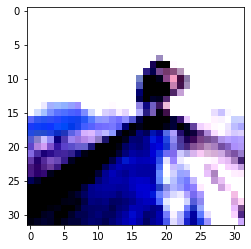

In [25]:
plt.imshow( ds_test_cifar100[0][0].permute(1, 2, 0))

### Group data into the right tasks

In [27]:
dss_train = [[] for _ in range(N_TASKS)]
for datapoint in ds_train_cifar100:
    task_id = datapoint[1] // 10
    dss_train[task_id].append((datapoint[0],
                               torch.tensor(datapoint[1] % 10)))

In [28]:
dss_test = [[] for _ in range(N_TASKS)]
for datapoint in ds_test_cifar100:
    task_id = datapoint[1] // 10
    dss_test[task_id].append((datapoint[0],
                              torch.tensor(datapoint[1] % 10)))

In [29]:
dls_train = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in dss_train]
dls_test = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False) for ds in dss_test]

# Fine-Tuning

### FineTune (class)

In [30]:
class FineTune(BaseClassifier):

    def __init__(self, config):
        super(FineTune, self).__init__(config)

## training functions

### train_finetune

In [31]:
def train_finetune(model, dataloader, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for X, y in dataloader:

        optimizer.zero_grad()

        output = model(X)

        loss = criterion(output, y)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

### fit_finetune

In [32]:
def fit_finetune(
    model,
    optimizer,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    task_id = config["curr_task_id"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #TODO: CHANGE, add change back to right head
            evaluate_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)

        start_time = time.time()

        train_loss = train_finetune(model, dls_train[task_id], optimizer, criterion, clip)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #TODO: CHANGE, add change back to right head
            evaluate_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)


        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

    if eval_within:
        return total_loss, total_hits
    return None, None

### repeat_func, init_func

In [33]:
def filter_params2(model, keywords):
    """Returns list of Parameters which include keyword"""
    ret = []
    if isinstance(keywords, list):
        for name, param in model.named_parameters():
            for keyword in keywords:
                if keyword in name:
                    ret.append(name)
        return ret
    else:
        for name, param in model.named_parameters():
            if keywords in name:
                ret.append(name)
        return ret

In [34]:
def init_func_finetune(config):
    nmodel = FineTune(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = dict()
    return nmodel, criterion, pass_on_variables

def repeat_func_finetune(model, criterion, config, pass_on_variables):

    if config["multi_head"]:
        optimizer = model.opts[config["curr_task_id"]]
        model.set_head(config["curr_task_id"])
    else:
        optimizer = model.opts[0]

    # optimizer = optim.Adam(filter_params(model, names),
    #                        lr=config["learning_rate"],
    #                        betas=config["betas"])

    fit_finetune(model, optimizer, criterion, config)

    model.task_update()

    return model, None, None

### config

In [ ]:
"""
config: configuration dictionary for experiment.
Variables starting with 'curr' are changed within the experiment.

Parameters
----------
experiment_name : string
    Name for the experiment
n_repetitions : int
    Amount of repetitions the experiment has
n_tasks_total : int
    Amount of tasks in total (CIFAR10x10 has 10)
n_datasets : int
    Amount of datasets, is 2 if you only have train and test,
    but is 3 if you have train, valid and test.
device : torch.device
    gpu or cpu depending on what is available
schedule : list of tuples: [(task1, epochs1), (task2, epochs2), ...]
    Defines which task is trained on for how many tuples
clip : float
    clip for which gradients should be clipped during training, helps for more
    stable training and if gradients explode.
eval_within : Bool
    Switch whether performance is evaluated within a task or not
step_size_eval : int
    If eval_within, then this value determines after how many epochs within
    a repetition performance is evaluated.
learining_rate : float
    learning rate for optimizer
betas : tuple(float, float)
    betas for Adam Optimizer
dls_train : list[DataLoader1, DataLoader2,...]
    The Dataloader for the corresponding task_id at the index:
    Task1, idx=0, DataLoader1; Task2, idx=1, DataLoader2;...
dls_test : list[DataLoader1, DataLoader2,...]
    Same as dls_train but for test
hidden1_dim : int

hiddem2_dim : int

output_dim : int
    dimensionality of task output (CIFAR10x10 has 10, because 10 classes for
    each task)
"""

config = {
    "experiment_name": "finetune",
    "n_repetitions": 1,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "device": DEVICE,
    "schedule": not_interleaved,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": None,
    "output_dim": OUTPUT_DIM,
    "multi_head": False,
}

### experiment single-head

In [ ]:
hist_losses, hist_hitsss, _, _, models = experiment(config, init_func_finetune, repeat_func_finetune)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: finetune.s0.t0.e50
Epoch: 01 | Time: 0m 1s | R0 T0
	Train Loss: 1.582 | Train PPL:   4.865
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 1.165 | Train PPL:   3.206
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 0.997 | Train PPL:   2.709
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.839 | Train PPL:   2.314
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.706 | Train PPL:   2.025
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.594 | Train PPL:   1.811
Epoch: 07 | Time: 0m 2s | R0 T0
	Train Loss: 0.483 | Train PPL:   1.621
Epoch: 08 | Time: 0m 3s | R0 T0
	Train Loss: 0.385 | Train PPL:   1.469
Epoch: 09 | Time: 0m 3s | R0 T0
	Train Loss: 0.302 | Train PPL:   1.353
Epoch: 10 | Time: 0m 2s | R0 T0
	Train Loss: 0.249 | Train PPL:   1.283
Epoch: 11 | Time: 0m 2s | R0 T0
	Train Loss: 0.205 | Train PPL:   1.228
Epoch: 12 | Time: 0m 2s | R0 T0
	Train Loss: 0.169 | Train PPL:   1.184
Epoch: 13 | Time: 0m 2s | R0 T0
	Train Loss: 0.141 | Train PPL:   1.151

The riddle of the Optimizer: If I filter out only fc1, fc2 and fc_out{current_task} then the result is different from just taking the optimizer over everything. It is not the convLayers, I have tried that.

### results

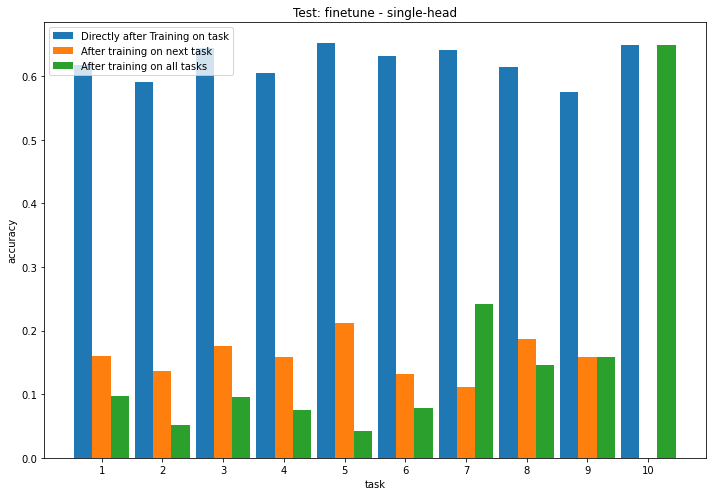

In [55]:
## TESTSET
plot_accuracy_tasks(hist_hitsss, config)

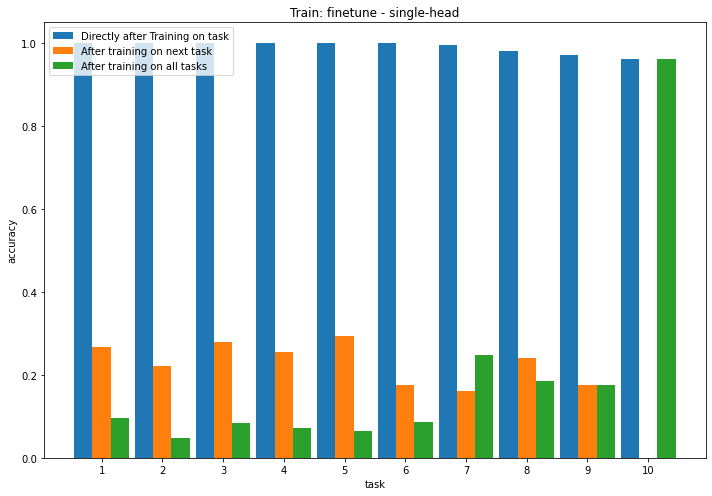

In [56]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss, config, dataset=0)

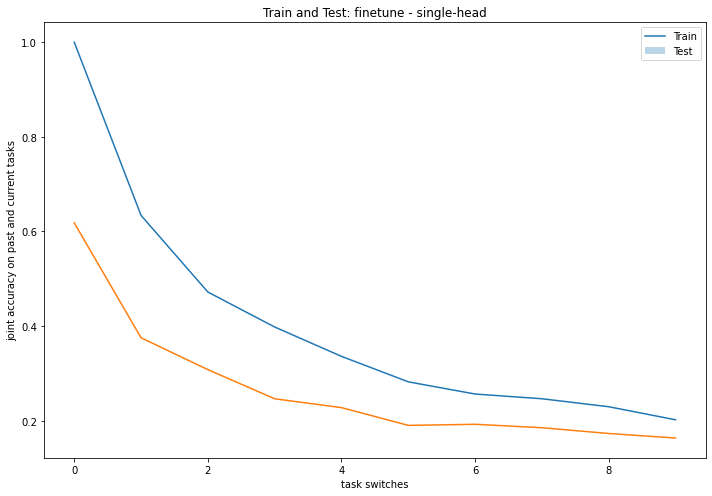

In [57]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss, config)

### experiment multi-head

In [ ]:
config["multi_head"] = True
hist_losses2, hist_hitsss2, _, _, models = experiment(config, init_func_finetune, repeat_func_finetune)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: finetune.s0.t0.e20
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 1.501 | Train PPL:   4.488
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 0.973 | Train PPL:   2.646
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 0.715 | Train PPL:   2.043
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.479 | Train PPL:   1.614
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.299 | Train PPL:   1.348
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.158 | Train PPL:   1.171
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss: 0.090 | Train PPL:   1.094
Epoch: 08 | Time: 0m 0s | R0 T0
	Train Loss: 0.055 | Train PPL:   1.057
Epoch: 09 | Time: 0m 0s | R0 T0
	Train Loss: 0.032 | Train PPL:   1.033
Epoch: 10 | Time: 0m 0s | R0 T0
	Train Loss: 0.015 | Train PPL:   1.015
Epoch: 11 | Time: 0m 0s | R0 T0
	Train Loss: 0.007 | Train PPL:   1.007
Epoch: 12 | Time: 0m 0s | R0 T0
	Train Loss: 0.007 | Train PPL:   1.007
Epoch: 13 | Time: 0m 0s | R0 T0
	Train Loss: 0.005 | Train PPL:   1.005

### results

In [63]:
## TESTSET
plot_accuracy_tasks(hist_hitsss2, config)

NameError: name 'hist_hitsss2' is not defined

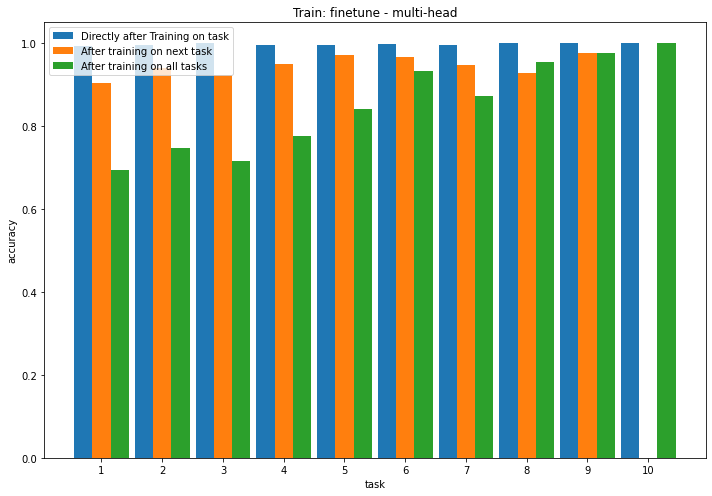

In [ ]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss2, config, dataset=0)

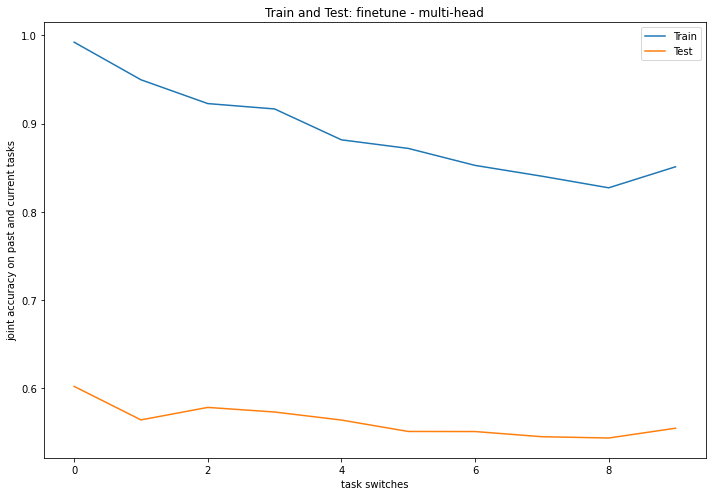

In [ ]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss2, config)

# EWC

### EWC (class)

In [ ]:
class EWC(BaseClassifier):

    def __init__(self, config):
        super(EWC, self).__init__(config)

        self.fishers = []
        self.opt_params = []
        self.ewc_lambda = config["ewc_lambda"]

    def task_update(self, dataloader, opt, crit):

        self.train()
        opt.zero_grad()

        # Accumulate Gradient to obtain fisher
        for X, y in dataloader:

            out = self(X)

            loss = crit(out, y)

            loss.backward()

        # Save fisher and optimal parameters
        self.fishers.append({})
        self.opt_params.append({})

        for name, param in self.named_parameters():
            if param.requires_grad:
                self.fishers[-1][name] = param.grad.data.clone().pow(2)
                self.opt_params[-1][name] = param.data.clone()

        if self.multi_head:
            self.new_head()

    def ewc_loss(self):
        """
        Returns ewc loss as float
        """
        name_latest = f"fc_out{self.heads - 1}"
        loss = 0
        for i in range(len(self.fishers)):
            for name, param in self.named_parameters():
                # prevent KeyError by excluding parameters fishers are not
                #  recorded for
                if param.requires_grad and name_latest not in name:
                    fisher = self.fishers[i][name]
                    opt_param = self.opt_params[i][name]
                    loss += ((fisher * (opt_param - param).pow(2)).sum()*
                            self.ewc_lambda)
        return loss

## training functions

#### train_ewc

In [ ]:
def train_ewc(model, dataloader, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for X, y in dataloader:

        optimizer.zero_grad()

        output = model(X)

        loss = criterion(output, y)

        loss += model.ewc_loss()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

#### fit_ewc

In [ ]:
def fit_ewc(
    model,
    optimizer,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)

        start_time = time.time()

        train_loss = train_ewc(model, dls_train[task_id], optimizer, criterion, clip)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)


        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

    if eval_within:
        return total_loss, total_hits
    return None, None

#### repeat_func, init_func

In [ ]:
def init_func_ewc(config):
    nmodel = EWC(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = None
    return nmodel, criterion, pass_on_variables

def repeat_func_ewc(model, criterion, config, pass_on_variables):

    if config["multi_head"]:
        optimizer = model.opts[config["curr_task_id"]]
        model.set_head(config["curr_task_id"])
    else:
        optimizer = model.opts[0]

    fit_ewc(model, optimizer, criterion, config)

    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]
    model.task_update(dls_train[task_id], optimizer, criterion)

    return model, None, None

#### config_ewc

In [ ]:
"""
New Parameters
--------------
ewc_lambda : int
    EWC parameter determining how big the influence of the old parameters
    should be compared to the adaption to the newly trained task
    (Balancing old task performance with new task performance)
"""

config_ewc = {
    "experiment_name": "ewc",
    "n_repetitions": 1,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "device": DEVICE,
    "schedule": not_interleaved,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": 2000,
    "output_dim": OUTPUT_DIM,
    "multi_head": False,
    "ewc_lambda": 1000,
}

### experiment single-head

In [ ]:
hist_losses_ewc, hist_hitsss_ewc, _, _, models = \
    experiment(config_ewc, init_func_ewc, repeat_func_ewc)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: ewc.s0.t0.e20
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 1.541 | Train PPL:   4.669
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 0.985 | Train PPL:   2.678
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 0.637 | Train PPL:   1.891
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.389 | Train PPL:   1.476
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.226 | Train PPL:   1.254
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.145 | Train PPL:   1.156
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss: 0.111 | Train PPL:   1.118
Epoch: 08 | Time: 0m 0s | R0 T0
	Train Loss: 0.106 | Train PPL:   1.111
Epoch: 09 | Time: 0m 0s | R0 T0
	Train Loss: 0.102 | Train PPL:   1.107
Epoch: 10 | Time: 0m 0s | R0 T0
	Train Loss: 0.077 | Train PPL:   1.080
Epoch: 11 | Time: 0m 0s | R0 T0
	Train Loss: 0.085 | Train PPL:   1.088
Epoch: 12 | Time: 0m 0s | R0 T0
	Train Loss: 0.065 | Train PPL:   1.068
Epoch: 13 | Time: 0m 0s | R0 T0
	Train Loss: 0.069 | Train PPL:   1.071
Epoc

### results

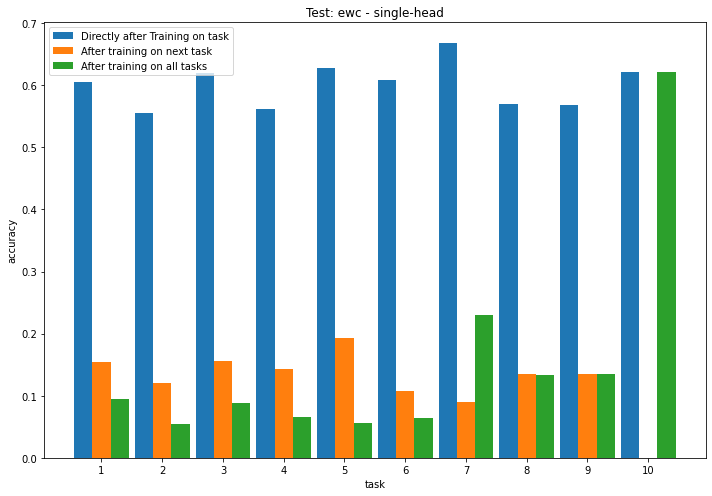

In [ ]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_ewc, config_ewc)

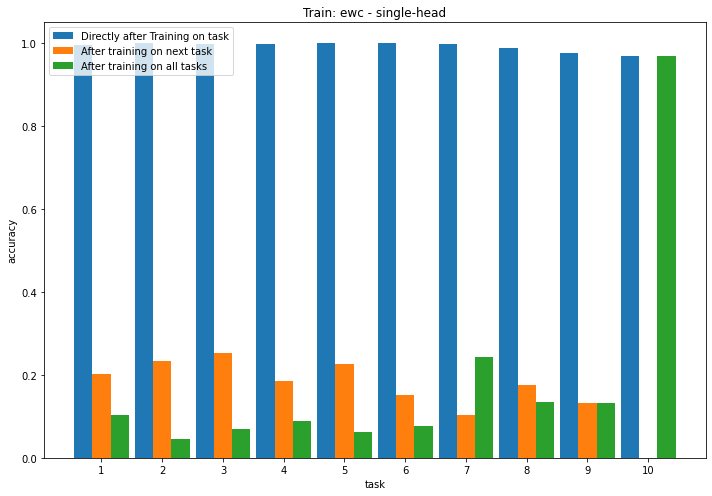

In [ ]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_ewc, config_ewc, dataset=0)

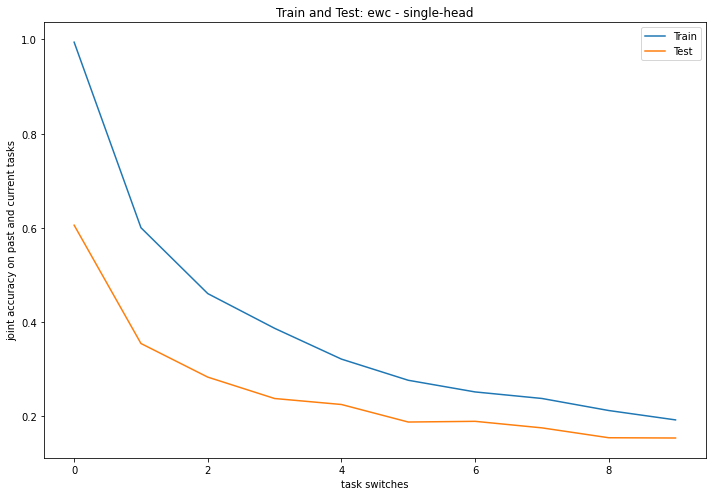

In [ ]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_ewc, config_ewc)

### experiment multi-head

In [ ]:
config_ewc["multi_head"] = True
hist_losses_ewc2, hist_hitsss_ewc2, _, _, models = \
    experiment(config_ewc, init_func_ewc, repeat_func_ewc)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: ewc.s0.t0.e20
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 1.533 | Train PPL:   4.631
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 0.954 | Train PPL:   2.596
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 0.634 | Train PPL:   1.884
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.375 | Train PPL:   1.455
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.237 | Train PPL:   1.267
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.149 | Train PPL:   1.161
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss: 0.111 | Train PPL:   1.117
Epoch: 08 | Time: 0m 0s | R0 T0
	Train Loss: 0.112 | Train PPL:   1.119
Epoch: 09 | Time: 0m 0s | R0 T0
	Train Loss: 0.098 | Train PPL:   1.103
Epoch: 10 | Time: 0m 0s | R0 T0
	Train Loss: 0.098 | Train PPL:   1.103
Epoch: 11 | Time: 0m 0s | R0 T0
	Train Loss: 0.079 | Train PPL:   1.083
Epoch: 12 | Time: 0m 0s | R0 T0
	Train Loss: 0.059 | Train PPL:   1.061
Epoch: 13 | Time: 0m 0s | R0 T0
	Train Loss: 0.061 | Train PPL:   1.063
Epoc

### results

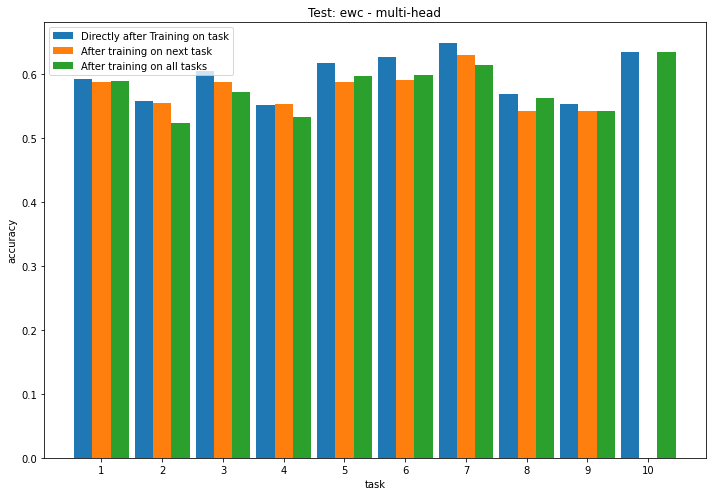

In [ ]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_ewc2, config_ewc, dataset=1)

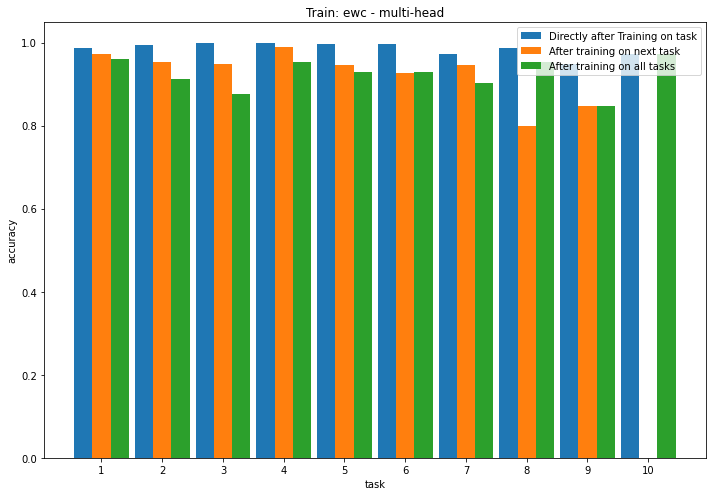

In [ ]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_ewc2, config_ewc, dataset=0)

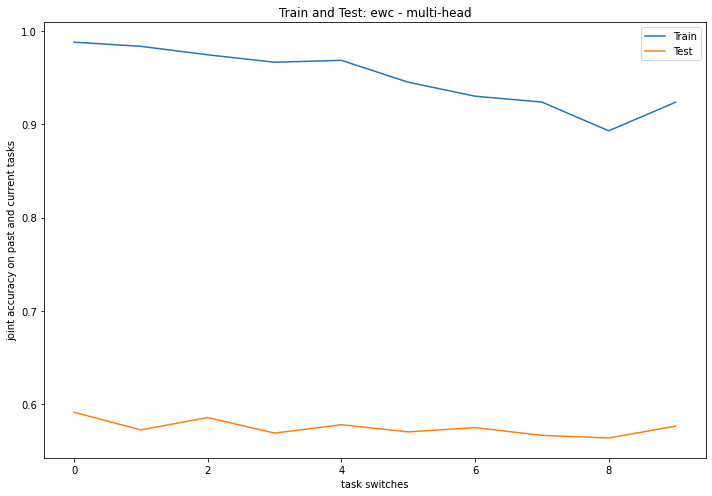

In [ ]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_ewc2, config_ewc)

# DynaMoE

### Gating (class)

In [28]:
class Gating(nn.Module):
    def __init__(self, config):
        super(Gating, self).__init__()

        self.device = config["device"]
        self.convLayers = copy.deepcopy(config["convLayers"])
        self.hidden1_dim = config["hidden1_dim"]
        self.n_max_experts = config["n_max_experts"]
        dropout = config["dropout"]

        self.convLayers.requires_grad_(False)

        self.fc1 = nn.Linear(self.convLayers.out_units, self.hidden1_dim)
        self.nl1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.energy = nn.Linear(self.hidden1_dim, self.n_max_experts)

        # optimizer
        self.opt = optim.Adam(self.parameters(),
                              lr=config["learning_rate"],
                              betas=config["betas"])

        self.to(self.device)

    def forward(self, X):

        X1 = self.convLayers(X)

        X2 = self.dropout(self.nl1(self.fc1(torch.flatten(X1, start_dim=1))))

        X3 = self.energy(X2)
        #X3 = [batch_size, n_max_experts]

        return X3

### Expert (class)

In [28]:
class Expert(BaseClassifier):
    def __init__(self, config):
        super(Expert, self).__init__(config)

        # for readability in DynaMoE class
        self.opt = self.opts[0]

### DynaMoE (class)

In [29]:
class DynaMoE(nn.Module):
    def __init__(self, config):
        super(DynaMoE, self).__init__()

        self.config_gating = config["config_gating"]
        self.config_expert = config["config_expert"]
        self.device = config["device"]
        self.gating_class = config["gating_class"]
        self.expert_class = config["expert_class"]

        # init gating
        self.gating = self.gating_class(self.config_gating)

        # experts
        self.n_experts = 0
        self.curr_expert = 0
        self.new_expert()

        # Mode
        self.set_mode("train_gating_new_expert")
        
    def forward(self, X, showgating=False):
        # Get Gating outputs
        output_gating = self.gating(X).mean(dim=0)
        #print(output_gating.shape, "mean")
        #print(self.gating(X).shape, "o gating")
        #print(f"      o_gating_mean{output_gating}")
        if showgating:
            print(output_gating)
        masked_gating = output_gating[:self.n_experts]
        chosen_expert = torch.argmax(masked_gating)
        #print(f"               {masked_gating}")

        name = f"expert{chosen_expert}"
        expert = self.get_submodule(name)
        
        return expert(X)

    def new_expert(self):
        """
        Creates a new expert
        """
        name = f"expert{self.n_experts}"
        
        self.add_module(name, self.expert_class(self.config_expert).
                        to(self.device))
        self.curr_expert = self.n_experts
        self.n_experts += 1
    
    def set_mode(self, mode_string):
        """
        Sets the mode of DynaMoE, determines what the next mode is

        Parameters
        ----------
        mode_string: string
            "train_gating_old_expert": has a trained expert and only trains the
                the gating
            "train_gating_new_expert": has an untrained expert, but trains only
                the gating
            "train_gating_expert": trains gating and expert simultanously
            "create_new_expert": creates a new expert
        """
        self.epoch_count = 0
        self.mode = mode_string
        if (mode_string == "train_gating_new_expert" or
            mode_string == "train_gating_old_expert"):
            print("----------------------------------- PHASE: GATING ONLY")
            # Set gating to train, rest to eval and grad to False
            self.gating.train()
            for e_id in range(self.n_experts):
                name = f"expert{e_id}"
                expert = self.get_submodule(name)
                expert.eval()
                expert.requires_grad_(False)
            
            if mode_string == "train_gating_new_expert":
                self.next_mode = "train_gating_expert"
            else:
                self.next_mode = "create_new_expert"

        elif mode_string == "create_new_expert":
            self.new_expert()
            print("----------------------------------- CREATED NEW EXPERT")
            self.set_mode("train_gating_new_expert")

        elif mode_string == "train_gating_expert":
            print("----------------------------------- PHASE: GATING AND EXPERT")
            self.gating.train()
            for e_id in range(self.n_experts):
                name = f"expert{e_id}"
                expert = self.get_submodule(name)
                if e_id == self.curr_expert:
                    expert.train()
                    expert.requires_grad_(True)
                else:
                    expert.requires_grad_(False)

            self.next_mode = "train_gating_old_expert"
        else:
            raise Error("Incorrect mode")

    def task_update(self):
        """
        if training on expert and gating, stop doing that and change mode
        """
        if self.mode == "train_gating_expert":
            self.set_mode(self.next_mode)

## training functions

#### train_dmoe_gating

In [ ]:
def train_dmoe_gating(model, dataloader, criterion, clip):

    epoch_loss = 0

    for X, y in dataloader:

        batch_size = X.shape[0]

        ## Compute optimal choice
        loss_experts = torch.empty((model.n_experts,), device=model.device)
        for e_id in range(model.n_experts):
            name = f"expert{e_id}"

            expert = model.get_submodule(name)

            output_expert = expert(X)

            loss_experts[e_id] = criterion(output_expert, y)

        gating_target = loss_experts.argmin().repeat(batch_size)

        model.gating.opt.zero_grad()

        gating_output = model.gating(X)

        loss = criterion(gating_output, gating_target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.gating.parameters(), clip)

        model.gating.opt.step()

        gating_prediction = gating_output.mean(dim=0)[:model.n_experts].argmax()
        epoch_loss += loss_experts[gating_prediction]

    return epoch_loss / len(dataloader)

#### train_dmoe_expert

In [30]:
def train_dmoe_expert(model, dataloader, criterion, clip):

    name = f"expert{model.curr_expert}"

    expert = model.get_submodule(name)

    epoch_loss = 0

    for X, y in dataloader:

        expert.opt.zero_grad()

        output = expert(X)

        loss = criterion(output, y)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(expert.parameters(), clip)

        expert.opt.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

#### train_dmoe

In [ ]:
def train_dmoe(model, dataloader, criterion, clip):

    if model.mode == "train_gating_expert":
        train_dmoe_gating(model, dataloader, criterion, clip)
        loss = train_dmoe_expert(model, dataloader, criterion, clip)
    elif model.mode == "train_gating_new_expert":
        loss = train_dmoe_gating(model, dataloader, criterion, clip)
    elif model.mode == "train_gating_old_expert":
        loss = train_dmoe_gating(model, dataloader, criterion, clip)
    else:
        raise Error("undefined model mode")

    return loss

#### fit_dmoe

In [ ]:
def fit_dmoe(
    model,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)

        start_time = time.time()

        train_loss = train_dmoe(model, dls_train[task_id], criterion, clip)
        # Test hits performance
        accuracy = evaluate(model, dls_train[task_id], hitsLoss)
        model.epoch_count +=1

        end_time = time.time()

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        # Check for conditions whether to change into new mode or not
        # if model.last_accuracy - accuracy > config["threshhold_accuracy_loss"]:
        #     # 1. Condition: a high jump into worse performance
        #     model.set_mode(model.next_mode)
        if ((model.mode == "train_gating_new_expert" or
             model.mode == "train_gating_old_expert") and
            accuracy < config["desired_performance"] and
            model.epoch_count >= config["limit_epochs_new_mode"]):
            model.set_mode(model.next_mode)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tTrain Acc: {accuracy:.3f}')

    if eval_within:
        return total_loss, total_hits
    return None, None

#### repeat_func, init_func

In [ ]:
def init_func_dmoe(config):
    nmodel = DynaMoE(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = None
    return nmodel, criterion, pass_on_variables

def repeat_func_dmoe(model, criterion, config, pass_on_variables):

    fit_dmoe(model, criterion, config)

    model.task_update()

    return model, None, None

#### config_dmoe_expert

In [ ]:
config_dmoe_expert = {
    "device": DEVICE,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": 2000,
    "output_dim": OUTPUT_DIM,
    "multi_head": False,
}

#### config_dmoe_gating

In [ ]:
config_dmoe_gating = {
    "device": DEVICE,
    "batch_size": BATCH_SIZE,
    "convLayers": convLayers,
    "hidden1_dim": 100,
    "n_max_experts": 20,
    "dropout": 0.5,
    "learning_rate": 0.01,
    "betas": BETAS,
}

#### config_dmoe

In [ ]:
"""
New Parameters
--------------
desired_performance : float[0,1]
    Desired performance of model on training set in ratio of accuractly
    classified examples.
limit_duration : int
    Amount of epochs model is trained until it initializes a new expert
threshhold_accuracy_loss : float [0,1]
    Percentage of accuracy loss between epochs, if it is above during
    training, the network will consolidate its weights
    [not used, since Tsuda are not doing that but giving a task_change signal]
"""

config_dmoe = {
    "experiment_name": "dynamoe",
    "n_repetitions": N_REPETITIONS,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "batch_size": BATCH_SIZE,
    "device": DEVICE,
    "schedule": not_interleaved,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "config_gating": config_dmoe_gating,
    "config_expert": config_dmoe_expert,
    "multi_head": False,
    "desired_performance": 0.98,
    "limit_epochs_new_mode": 1,
    "threshhold_accuracy_loss": 0.25,
    "gating_class": Gating,
    "expert_class": Expert,
}
# debug
# config_dmoe["schedule"] = dbg_not_interleaved
config_dmoe["n_repetitions"] = 1

NameError: ignored

### experiment

In [ ]:
hist_losses_dmoe, hist_hitsss_dmoe, _, _, models = \
    experiment(config_dmoe, init_func_dmoe, repeat_func_dmoe)

NameError: ignored

### results

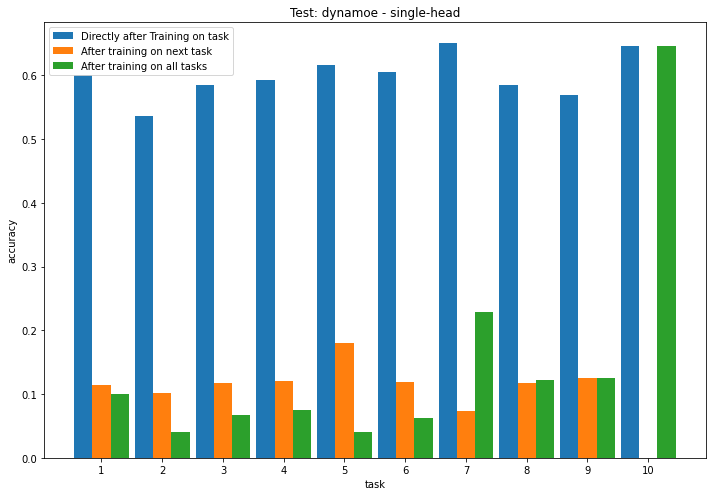

In [ ]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_dmoe, config_dmoe)

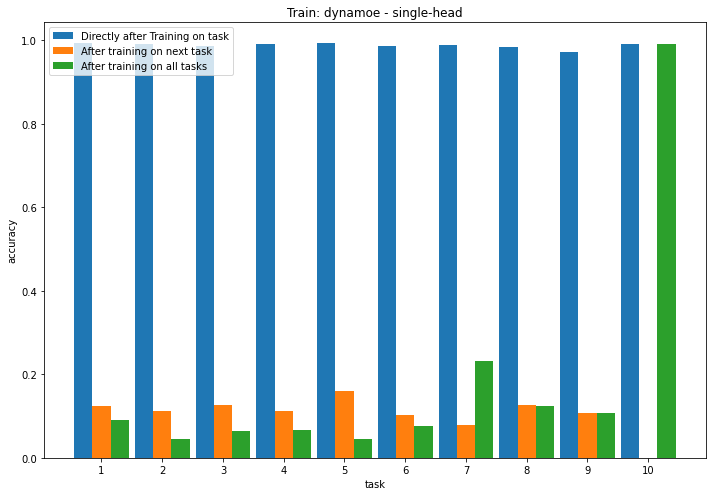

In [ ]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_dmoe, config_dmoe, dataset=0)

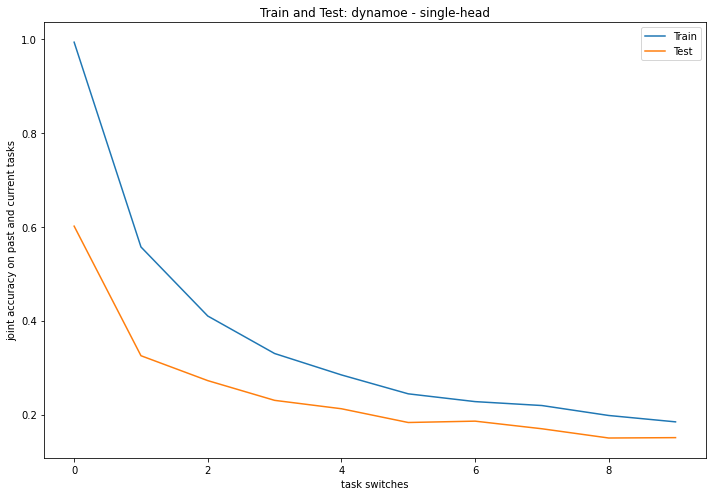

In [ ]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_dmoe, config_dmoe)

# DynaMoE with Oracle

DynaMoE fails miserably because the gating network is not able to learn continually. Although if we would have optimal gating, DynaMoE becomes extremely effective:
In the best case, our gating always exactly knows which task the current input belongs to. This is shown in following section.

Thus this section represents optimal performance, the section after this implements a method which approximates that performance but does not need a task oracle anymore.

### DynaMoE_oracle (class)

In [ ]:
class Dummy(nn.Module):
    def __init__(self, *obj):
        super(Dummy, self).__init__()
        #self.dummy = nn.Linear(1,1)

class DynaMoE_oracle(DynaMoE):
    def __init__(self, config):
        config["config_gating"] = None
        config["gating_class"] = Dummy

        super(DynaMoE_oracle, self).__init__(config)

    def forward(self, X):

        chosen_expert = min(self.n_experts - 1, self.curr_head)
        name = f"expert{chosen_expert}"
        expert = self.get_submodule(name)
        
        return expert(X)

## training fuctions

#### train_dmoe_oracle

In [ ]:
def train_dmoe_oracle(model, dataloader, criterion, clip):

    if model.mode == "train_gating_expert":
        loss = train_dmoe_expert(model, dataloader, criterion, clip)
    elif model.mode == "train_gating_new_expert":
        # Oracle Gating does not need training
        loss = 0
    elif model.mode == "train_gating_old_expert":
        # Oracle Gating does not need training
        loss = 0
    else:
        raise Error("undefined model mode")

    return loss

#### fit_dmoe_oracle

In [ ]:
def fit_dmoe_oracle(
    model,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)
        
        start_time = time.time()
        
        train_loss = train_dmoe_oracle(model, dls_train[task_id], criterion, clip)
        # Test hits performance
        accuracy = evaluate(model, dls_train[task_id], hitsLoss)
        model.epoch_count +=1
        
        end_time = time.time()

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        # Check for conditions whether to change into new mode or not
        # if model.last_accuracy - accuracy > config["threshhold_accuracy_loss"]:
        #     # 1. Condition: a high jump into worse performance
        #     model.set_mode(model.next_mode)
        if ((model.mode == "train_gating_new_expert" or
             model.mode == "train_gating_old_expert") and
            accuracy < config["desired_performance"] and
            model.epoch_count >= config["limit_epochs_new_mode"]):
            model.set_mode(model.next_mode)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tTrain Acc: {accuracy:.3f}')
    
    if eval_within:
        return total_loss, total_hits
    return None, None

#### repeat_func, init_func

In [ ]:
def init_func_dmoe_oracle(config):
    nmodel = DynaMoE_oracle(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = None
    return nmodel, criterion, pass_on_variables

def repeat_func_dmoe_oracle(model, criterion, config, pass_on_variables):

    if config["multi_head"]:
        model.curr_head = config["curr_task_id"]

    fit_dmoe_oracle(model, criterion, config)

    model.task_update()
    
    return model, None, None

#### config_dmoe_expert_oracle

In [ ]:
config_dmoe_expert_oracle = {
    "device": DEVICE,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": 2000,
    "output_dim": OUTPUT_DIM,
    "multi_head": False,
}

#### config_dmoe_oracle

In [ ]:
"""
New Parametersconfig_dmoe_expert
--------------
desired_performance : float[0,1]
    Desired performance of model on training set in ratio of accuractly
    classified examples.
limit_duration : int
    Amount of epochs model is trained until it initializes a new expert
threshhold_accuracy_loss : float [0,1]
    Percentage of accuracy loss between epochs, if it is above during
    training, the network will consolidate its weights
    [not used, since Tsuda are not doing that but giving a task_change signal]
"""

config_dmoe_oracle = {
    "experiment_name": "DynaMoE with oracle",
    "n_repetitions": N_REPETITIONS,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "batch_size": BATCH_SIZE,
    "device": DEVICE,
    "schedule": not_interleaved,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "config_expert": config_dmoe_expert_oracle,
    "multi_head": True,
    "desired_performance": 0.98,
    "limit_epochs_new_mode": 1,
    "threshhold_accuracy_loss": 0.25,
    "gating_class": Gating,
    "expert_class": Expert,
}
# debug
# config_dmoe["schedule"] = dbg_not_interleaved
config_dmoe_oracle["n_repetitions"] = 1

### experiment

In [ ]:
hist_losses_dmoe_oracle, hist_hitsss_dmoe_oracle, _, _, models = \
    experiment(config_dmoe_oracle, init_func_dmoe_oracle,
               repeat_func_dmoe_oracle)

@@@@@@@@@ Repetition   0 @@@@@@@@@
----------------------------------- TRAIN GATING ONLY

SCHEDULE: dynamoe.s0.t0.e20
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 0.000 | Train PPL:   1.000
	Train Acc: 0.106
----------------------------------- TRAIN GATING AND EXPERT
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 0.000 | Train PPL:   1.000
	Train Acc: 0.109
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 1.535 | Train PPL:   4.643
	Train Acc: 0.676
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.908 | Train PPL:   2.480
	Train Acc: 0.771
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.597 | Train PPL:   1.816
	Train Acc: 0.918
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.309 | Train PPL:   1.362
	Train Acc: 0.978
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss: 0.162 | Train PPL:   1.176
	Train Acc: 0.975
Epoch: 08 | Time: 0m 0s | R0 T0
	Train Loss: 0.092 | Train PPL:   1.097
	Train Acc: 0.988
Epoch: 09 | Time: 0m 0s | R0 T0
	Train Loss: 0.068 | Train PPL:   1.070
	Train Acc: 0.978
Epoch: 10 | 

### results

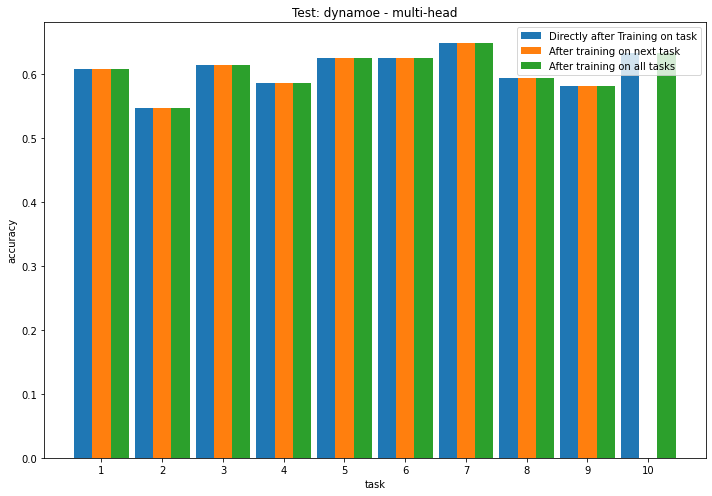

In [ ]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_dmoe_oracle, config_dmoe_oracle)

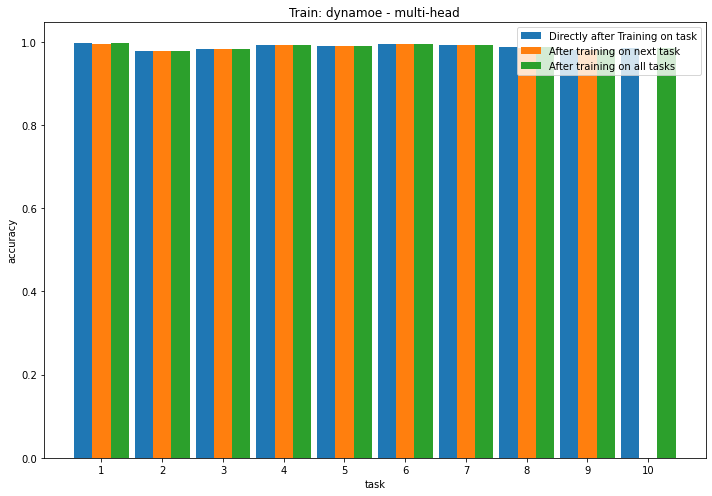

In [ ]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_dmoe_oracle, config_dmoe_oracle, dataset=0)

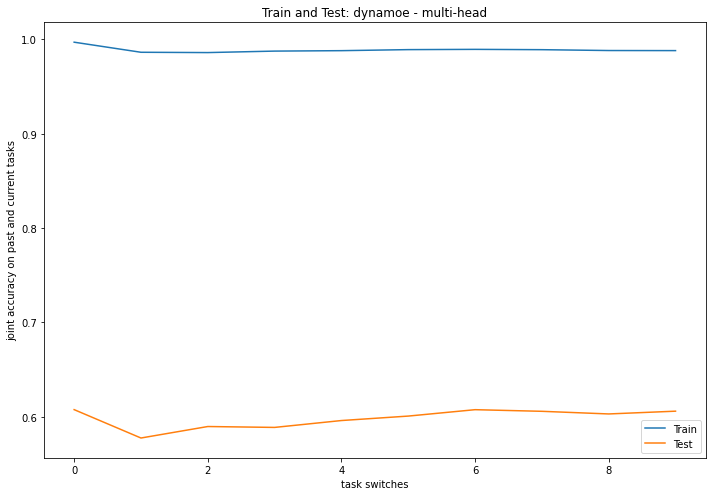

In [ ]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_dmoe_oracle, config_dmoe_oracle)

# DynaMoE with Gating Autoencoders

To prevent DynaMoE's gate from forgetting which expert to give the respective task to without retraining on old tasks or using a task oracle, the Gating Autoencoder from Aljundi 2017 is implemented.

In order for the AutoEncoder gates to work, the data needs to be normalized
AFTER going through the convLayers. This normalization ideally happens on a
large dataset such as imagenet, but now is only done on cifar100 in the seperate
file `compute_mean_std_cnn_cifar100.ipnb`

#### gae preprocess

In [31]:
means = torch.tensor([0.3675, 0.3050, 0.3678, 0.3993, 0.2538, 0.4292, 0.4093, 0.4162, 0.1650, 0.2584, 0.3470, 0.6910, 0.3170, 0.3576, 0.3422, 0.5355, 0.3403, 0.4007, 0.4311, 0.3835, 0.2333, 0.3313, 0.3861, 0.5779, 0.3348, 0.3360, 0.2470, 0.5728, 0.2147, 0.2532, 0.5708, 0.5216, 0.1153, 0.3762, 0.3573, 0.6760, 0.3503, 0.3183, 0.3918, 0.4665, 0.2565, 0.4752, 0.2887, 0.4796, 0.2507, 0.3514, 0.3140, 0.5348, 0.2286, 0.2614, 0.3718, 0.6396, 0.3978, 0.4147, 0.4028, 0.3256, 0.3294, 0.4257, 0.3350, 0.4256, 0.2804, 0.5108, 0.3273, 0.3295, 0.3815, 0.4749, 0.2431, 0.3955, 0.2424, 0.3218, 0.3497, 0.5949, 0.3411, 0.3484, 0.4228, 0.4088, 0.2468, 0.3322, 0.5202, 0.4392, 0.2458, 0.2628, 0.5270, 0.5120, 0.2775, 0.2773, 0.5170, 0.4215, 0.3596, 0.5184, 0.3428, 0.3916, 0.2917, 0.5244, 0.3561, 0.3683, 0.3314, 0.2984, 0.2974, 0.5779, 0.2083, 0.2376, 0.3983, 0.6485, 0.3362, 0.3510, 0.3520, 0.4940, 0.2201, 0.4031, 0.3250, 0.5962, 0.2458, 0.4624, 0.2977, 0.4625, 0.2393, 0.3893, 0.4570, 0.4106, 0.2311, 0.3242, 0.3973, 0.5477, 0.3083, 0.3222, 0.3153, 0.5851, 0.2774, 0.4046, 0.3503, 0.4639, 0.2704, 0.3547, 0.4496, 0.4492, 0.1641, 0.4168, 0.4375, 0.4814, 0.2445, 0.3048, 0.3922, 0.5792, 0.3887, 0.3398, 0.5124, 0.2511, 0.2899, 0.3037, 0.5047, 0.4217, 0.4087, 0.4309, 0.2946, 0.3665, 0.2669, 0.3530, 0.4362, 0.4530, 0.1802, 0.3968, 0.3970, 0.5619, 0.3495, 0.4469, 0.4232, 0.2852, 0.3426, 0.3701, 0.5616, 0.2972, 0.5472, 0.2994, 0.3388, 0.2664, 0.2332, 0.3866, 0.4384, 0.4611, 0.2501, 0.3021, 0.4890, 0.4397, 0.2597, 0.3486, 0.2993, 0.5596, 0.1722, 0.2097, 0.3983, 0.7399, 0.2700, 0.3666, 0.4715, 0.4151, 0.2738, 0.3384, 0.3116, 0.5879, 0.3491, 0.4454, 0.4258, 0.3497, 0.3474, 0.3966, 0.4309, 0.3880, 0.3449, 0.2072, 0.5254, 0.4214, 0.3208, 0.3281, 0.5194, 0.3229, 0.4240, 0.3713, 0.2933, 0.3967, 0.3335, 0.3955, 0.3947, 0.3976, 0.3361, 0.4201, 0.3274, 0.3588, 0.1935, 0.4248, 0.3474, 0.5374, 0.3558, 0.2820, 0.4120, 0.4761, 0.1632, 0.4637, 0.2848, 0.5530, 0.3021, 0.4440, 0.2741, 0.4592, 0.2538, 0.4380, 0.3248, 0.5027, 0.1965, 0.4129, 0.2643, 0.5940, 0.3808, 0.2956, 0.4113, 0.4647, 0.2247, 0.2939, 0.3555, 0.6432, 0.3224, 0.4532, 0.2764, 0.4643, 0.3943, 0.3448, 0.4232, 0.4200, 0.3059, 0.3518, 0.3859, 0.4835, 0.2660, 0.5323, 0.3337, 0.3396, 0.2522, 0.4095, 0.4110, 0.4500, 0.2124, 0.3367, 0.3934, 0.5415, 0.2347, 0.3556, 0.3550, 0.5817, 0.2330, 0.4931, 0.2911, 0.5310, 0.2347, 0.4638, 0.3036, 0.5038, 0.2934, 0.5281, 0.3445, 0.3642, 0.2757, 0.3068, 0.4113, 0.5073, 0.4152, 0.3743, 0.3648, 0.3743, 0.1987, 0.3851, 0.3322, 0.6074, 0.2809, 0.4795, 0.2335, 0.5412, 0.2280, 0.3809, 0.3264, 0.5438, 0.2792, 0.4042, 0.3903, 0.4653, 0.1529, 0.2873, 0.3680, 0.7174, 0.1431, 0.2629, 0.3795, 0.7409, 0.2071, 0.2284, 0.4540, 0.5855, 0.2550, 0.3618, 0.4102, 0.4964, 0.1965, 0.3238, 0.4275, 0.5758, 0.2707, 0.3829, 0.4495, 0.4435, 0.1589, 0.3488, 0.4204, 0.5570, 0.1666, 0.3422, 0.3001, 0.6535, 0.2552, 0.4455, 0.3413, 0.4975, 0.1963, 0.3399, 0.3873, 0.5543, 0.2302, 0.5799, 0.3400, 0.3501, 0.2753, 0.4078, 0.3944, 0.3474, 0.1354, 0.3172, 0.4489, 0.6235, 0.2297, 0.3563, 0.3538, 0.5818, 0.2245, 0.4660, 0.3268, 0.4621, 0.2731, 0.4787, 0.3329, 0.4015, 0.1737, 0.2753, 0.5420, 0.5189, 0.2698, 0.3572, 0.3816, 0.5258, 0.3019, 0.2482, 0.5899, 0.4110, 0.2006, 0.2996, 0.5069, 0.5139, 0.3199, 0.3927, 0.3559, 0.4340, 0.2508, 0.3962, 0.3303, 0.5352, 0.2117, 0.4766, 0.2119, 0.5993, 0.1759, 0.4007, 0.3320, 0.5669, 0.2937, 0.3528, 0.2860, 0.5061, 0.2781, 0.3565, 0.3413, 0.4979, 0.3225, 0.3920, 0.2517, 0.5967, 0.1434, 0.2153, 0.2983, 0.7763, 0.3020, 0.4954, 0.2394, 0.5180, 0.2417, 0.4211, 0.2792, 0.5158, 0.2227, 0.3235, 0.3705, 0.5859, 0.2675, 0.3804, 0.3675, 0.4421, 0.2261, 0.3338, 0.2997, 0.6021, 0.1368, 0.3264, 0.4397, 0.6400, 0.3135, 0.3820, 0.3828, 0.4229, 0.2788, 0.5010, 0.2708, 0.4571, 0.2772, 0.4681, 0.2414, 0.5507, 0.2972, 0.4050, 0.3172, 0.5511, 0.2057, 0.4035, 0.2831, 0.5548, 0.2258, 0.3103, 0.3273, 0.6281, 0.3552, 0.3554, 0.3100, 0.4586, 0.2574, 0.3006, 0.3684, 0.5848, 0.2209, 0.4859, 0.4237, 0.3898, 0.2249, 0.3387, 0.3313, 0.6205, 0.2419, 0.4537, 0.3517, 0.4504, 0.1302, 0.2838, 0.3532, 0.7224, 0.3296, 0.3205, 0.4238, 0.4400, 0.2345, 0.5518, 0.2138, 0.4992, 0.1929, 0.5347, 0.2627, 0.5044, 0.3259, 0.2220, 0.4199, 0.5078, 0.1287, 0.2538, 0.4324, 0.7098, 0.3226, 0.4305, 0.2864, 0.4420, 0.3343, 0.2949, 0.3721, 0.4554, 0.1933, 0.3434, 0.3491, 0.6373, 0.2105, 0.2595, 0.5203, 0.5622, 0.3881, 0.4895, 0.2337, 0.4419, 0.1365, 0.4391, 0.2397, 0.6495, 0.3823, 0.2711, 0.5025, 0.3544, 0.2788, 0.3328, 0.3601, 0.5540, 0.3518, 0.2806, 0.5003, 0.4018, 0.2138, 0.2883, 0.3818, 0.6406, 0.4418, 0.4369, 0.2840, 0.3425, 0.0960, 0.3862, 0.2832, 0.6798, 0.2244, 0.3354, 0.3663, 0.5673, 0.2135, 0.2118, 0.4910, 0.5998, 0.2543, 0.5104, 0.2739, 0.5056, 0.2582, 0.3610, 0.3438, 0.5909, 0.2267, 0.5583, 0.2803, 0.4297, 0.1706, 0.4326, 0.3044, 0.5805, 0.1800, 0.3091, 0.3739, 0.6144, 0.1745, 0.3146, 0.3031, 0.6625, 0.1896, 0.3586, 0.4452, 0.5326, 0.2731, 0.4436, 0.3866, 0.4025, 0.3238, 0.4305, 0.2818, 0.4320, 0.2509, 0.3809, 0.3945, 0.5173, 0.3716, 0.3729, 0.4734, 0.3164, 0.2119, 0.3124, 0.3671, 0.6494, 0.3902, 0.4101, 0.3466, 0.3672, 0.2933, 0.3843, 0.3245, 0.4963, 0.2129, 0.3145, 0.3915, 0.5883, 0.3335, 0.4184, 0.2701, 0.4148, 0.4067, 0.3551, 0.4651, 0.2643, 0.2547, 0.3497, 0.4690, 0.4378, 0.3467, 0.3383, 0.4200, 0.3440, 0.1604, 0.2803, 0.3387, 0.6416, 0.3353, 0.3806, 0.3865, 0.3978, 0.1843, 0.5873, 0.2535, 0.5223, 0.2582, 0.4108, 0.3249, 0.5223, 0.2657, 0.3181, 0.4636, 0.4536, 0.3602, 0.3970, 0.3471, 0.4311, 0.2766, 0.4491, 0.3637, 0.4508, 0.2449, 0.3929, 0.4427, 0.3891, 0.3492, 0.5455, 0.2632, 0.3701, 0.2361, 0.3759, 0.4162, 0.4515, 0.2896, 0.4531, 0.3526, 0.4214, 0.2519, 0.5443, 0.2575, 0.4957, 0.3485, 0.5633, 0.2263, 0.3837, 0.2627, 0.4827, 0.2588, 0.5052, 0.2184, 0.4158, 0.3610, 0.5219, 0.1860, 0.4322, 0.2602, 0.6294, 0.2290, 0.3552, 0.4380, 0.5437, 0.2631, 0.3306, 0.3734, 0.5240, 0.1756, 0.4843, 0.2398, 0.6461, 0.2683, 0.4601, 0.3342, 0.3618, 0.2893, 0.3749, 0.3105, 0.5106, 0.2223, 0.3705, 0.3209, 0.5997, 0.3533, 0.3941, 0.3577, 0.4144, 0.1338, 0.3095, 0.3773, 0.6487, 0.1824, 0.4985, 0.1669, 0.6371, 0.3158, 0.3138, 0.4867, 0.4468, 0.2857, 0.3877, 0.3055, 0.5237, 0.2023, 0.2647, 0.4915, 0.6021, 0.3474, 0.3238, 0.4414, 0.3589, 0.2628, 0.2716, 0.4683, 0.4999, 0.1635, 0.3932, 0.4386, 0.5270, 0.2198, 0.3481, 0.3464, 0.5918, 0.1411, 0.2676, 0.4625, 0.6099, 0.2648, 0.3906, 0.3201, 0.5367, 0.3066, 0.3909, 0.3366, 0.4700, 0.2357, 0.4158, 0.3353, 0.5108, 0.3206, 0.3531, 0.4185, 0.4026, 0.2359, 0.3010, 0.4866, 0.5023, 0.2693, 0.3404, 0.4984, 0.4078, 0.3072, 0.4133, 0.3735, 0.3900, 0.2053, 0.3418, 0.5189, 0.3759, 0.2290, 0.4537, 0.4190, 0.3832, 0.4627, 0.4014, 0.3410, 0.2933, 0.3236, 0.3965, 0.3026, 0.4497, 0.2416, 0.3738, 0.3255, 0.5486, 0.3002, 0.3146, 0.3391, 0.4696, 0.2550, 0.4478, 0.3345, 0.5319, 0.1343, 0.3242, 0.3403, 0.7253, 0.2882, 0.4678, 0.2059, 0.5974, 0.1988, 0.3668, 0.3482, 0.6388, 0.3915, 0.4422, 0.1785, 0.4995, 0.2959, 0.2979, 0.4002, 0.5158, 0.3728, 0.4743, 0.2791, 0.3193, 0.2624, 0.3585, 0.2904, 0.5964, 0.2696, 0.5376, 0.2751, 0.4442, 0.2801, 0.4069, 0.4612, 0.4019, 0.3851, 0.4015, 0.2963, 0.4155, 0.0911, 0.3310, 0.3316, 0.7052, 0.3886, 0.2954, 0.4135, 0.3809, 0.2706, 0.2621, 0.4282, 0.5280, 0.2815, 0.3259, 0.3594, 0.5229, 0.2309, 0.4259, 0.3181, 0.5487, 0.2368, 0.4158, 0.3996, 0.4102, 0.2833, 0.3622, 0.4941, 0.3564, 0.3401, 0.4712, 0.2125, 0.3655, 0.2089, 0.4452, 0.3529, 0.4806, 0.2869, 0.4514, 0.4126, 0.3812, 0.2724, 0.3067, 0.4448, 0.5166, 0.3647, 0.3147, 0.4286, 0.4160, 0.2524, 0.2882, 0.3842, 0.5691, 0.2584, 0.2181, 0.5147, 0.5632, 0.1986, 0.3299, 0.4232, 0.5186, 0.2234, 0.3818, 0.4580, 0.4255, 0.3057, 0.3312, 0.4415, 0.3968, 0.2270, 0.2349, 0.5071, 0.4901, 0.1892, 0.4207, 0.3863, 0.5096, 0.2017, 0.4337, 0.4307, 0.4183, 0.2401, 0.3544, 0.4073, 0.4880, 0.1655, 0.3768, 0.3508, 0.6572, 0.3064, 0.4310, 0.4019, 0.3770, 0.2727, 0.2624, 0.3971, 0.5498, 0.3317, 0.4054, 0.3116, 0.4128, 0.3936, 0.3966, 0.3938, 0.3753, 0.2107, 0.3960, 0.4629, 0.4429, 0.2961, 0.2619, 0.4878, 0.5226, 0.2579, 0.2244, 0.4476, 0.5852, 0.1948, 0.4438, 0.3188, 0.4846, 0.4288, 0.2937, 0.2201, 0.5535, 0.2561, 0.2256, 0.5222, 0.4517, 0.2225, 0.3601, 0.2640, 0.6771, 0.2370, 0.3911, 0.2721, 0.5984])
stds = torch.tensor([0.4398, 0.4750, 0.5123, 0.6597, 0.4182, 0.6236, 0.5715, 0.7204, 0.3099, 0.4493, 0.5195, 0.8383, 0.4307, 0.5671, 0.5473, 0.8218, 0.5119, 0.6287, 0.5976, 0.6591, 0.4200, 0.5283, 0.5703, 0.8451, 0.4953, 0.5079, 0.4767, 0.8968, 0.3680, 0.5128, 0.7471, 0.7861, 0.3105, 0.5800, 0.6173, 0.9009, 0.4914, 0.5294, 0.5845, 0.7723, 0.3952, 0.6229, 0.4748, 0.7400, 0.4255, 0.5380, 0.5511, 0.7974, 0.3695, 0.4469, 0.5482, 0.8296, 0.4897, 0.5908, 0.5516, 0.6123, 0.5164, 0.6371, 0.5538, 0.6959, 0.4192, 0.6199, 0.5387, 0.5984, 0.5073, 0.6080, 0.4878, 0.6763, 0.3823, 0.5172, 0.5456, 0.8203, 0.4851, 0.5411, 0.5980, 0.6947, 0.4333, 0.6013, 0.7118, 0.7507, 0.4226, 0.4806, 0.7255, 0.7778, 0.4018, 0.5020, 0.6220, 0.7151, 0.4594, 0.6740, 0.5139, 0.7171, 0.4419, 0.6351, 0.5944, 0.6282, 0.4978, 0.5094, 0.5392, 0.8262, 0.3802, 0.4570, 0.5884, 0.8747, 0.4794, 0.5689, 0.5558, 0.7759, 0.3986, 0.6292, 0.5360, 0.8234, 0.3914, 0.6043, 0.5283, 0.7545, 0.4101, 0.5764, 0.6580, 0.7268, 0.4108, 0.5136, 0.5787, 0.7668, 0.4354, 0.5301, 0.5524, 0.8490, 0.3958, 0.5575, 0.5572, 0.7685, 0.4317, 0.5797, 0.6438, 0.7552, 0.3201, 0.5842, 0.6221, 0.7669, 0.3971, 0.4869, 0.5815, 0.7816, 0.4386, 0.5021, 0.5979, 0.4912, 0.4543, 0.5050, 0.6636, 0.7154, 0.5040, 0.5915, 0.5038, 0.6512, 0.4261, 0.6033, 0.5915, 0.7352, 0.3340, 0.5605, 0.5895, 0.8379, 0.4368, 0.6304, 0.5484, 0.5938, 0.4996, 0.5795, 0.6899, 0.5727, 0.6460, 0.5278, 0.5436, 0.5244, 0.3777, 0.5872, 0.6243, 0.7545, 0.4162, 0.5191, 0.6457, 0.6892, 0.3855, 0.5392, 0.5197, 0.8226, 0.3478, 0.4348, 0.6240, 0.9137, 0.4432, 0.5446, 0.6230, 0.6927, 0.4001, 0.5089, 0.5487, 0.8155, 0.4923, 0.5962, 0.5848, 0.6455, 0.4993, 0.5791, 0.5887, 0.6380, 0.4923, 0.4234, 0.6498, 0.7074, 0.4331, 0.4998, 0.6157, 0.5665, 0.4723, 0.5303, 0.4694, 0.6402, 0.5075, 0.6334, 0.5818, 0.7143, 0.4417, 0.5622, 0.5307, 0.6527, 0.3527, 0.5829, 0.5412, 0.8569, 0.4472, 0.4980, 0.5870, 0.7486, 0.2934, 0.5556, 0.4734, 0.7729, 0.4106, 0.6346, 0.4939, 0.7141, 0.3888, 0.5805, 0.5437, 0.7419, 0.3525, 0.5749, 0.4681, 0.8853, 0.5101, 0.5332, 0.6116, 0.7672, 0.3572, 0.4798, 0.5384, 0.8595, 0.4396, 0.6039, 0.4958, 0.7512, 0.4813, 0.5545, 0.5749, 0.7104, 0.4782, 0.5377, 0.6601, 0.8146, 0.4278, 0.6741, 0.5226, 0.6050, 0.4007, 0.6096, 0.5929, 0.7286, 0.4356, 0.5525, 0.6035, 0.7892, 0.3972, 0.5563, 0.5368, 0.8188, 0.4233, 0.6317, 0.5232, 0.7534, 0.3947, 0.6696, 0.5103, 0.7510, 0.4166, 0.6543, 0.5181, 0.6301, 0.3721, 0.4788, 0.5891, 0.7402, 0.5507, 0.5887, 0.5784, 0.6798, 0.3973, 0.5942, 0.5559, 0.8494, 0.4434, 0.6675, 0.4638, 0.8313, 0.3559, 0.5452, 0.5382, 0.8104, 0.4454, 0.6368, 0.6015, 0.7285, 0.3328, 0.5037, 0.5897, 0.9454, 0.3220, 0.4987, 0.5947, 0.9695, 0.3413, 0.4201, 0.5984, 0.7965, 0.3983, 0.5865, 0.6133, 0.7763, 0.4013, 0.5675, 0.6544, 0.8495, 0.4608, 0.5848, 0.6109, 0.7047, 0.2875, 0.4920, 0.5677, 0.7396, 0.3335, 0.5522, 0.5299, 0.8884, 0.3841, 0.5734, 0.5276, 0.7242, 0.3816, 0.5534, 0.6158, 0.8165, 0.3940, 0.6770, 0.5354, 0.6222, 0.3800, 0.5624, 0.5744, 0.6437, 0.3245, 0.5660, 0.6451, 0.8454, 0.4113, 0.5670, 0.5646, 0.8494, 0.3769, 0.6374, 0.5410, 0.7479, 0.4121, 0.6425, 0.5235, 0.6713, 0.3309, 0.4755, 0.7378, 0.8078, 0.4579, 0.5947, 0.6419, 0.7904, 0.4666, 0.4644, 0.6983, 0.7109, 0.3407, 0.5051, 0.6240, 0.7645, 0.4594, 0.5604, 0.5398, 0.7112, 0.3878, 0.6251, 0.5271, 0.8341, 0.3653, 0.6097, 0.4345, 0.7863, 0.3166, 0.5793, 0.5349, 0.8116, 0.4573, 0.5344, 0.5040, 0.7672, 0.3985, 0.5227, 0.5385, 0.7490, 0.4497, 0.5890, 0.4561, 0.8253, 0.2942, 0.4105, 0.4806, 0.8982, 0.4682, 0.6330, 0.4414, 0.7654, 0.3800, 0.6017, 0.5180, 0.7884, 0.4027, 0.5552, 0.5943, 0.8467, 0.4044, 0.5412, 0.5460, 0.6996, 0.3546, 0.5250, 0.5635, 0.8588, 0.2932, 0.5512, 0.6031, 0.8306, 0.5004, 0.6023, 0.5842, 0.7228, 0.4399, 0.6668, 0.5001, 0.7732, 0.4533, 0.6309, 0.4654, 0.7866, 0.4677, 0.6009, 0.5370, 0.8166, 0.3724, 0.5713, 0.4797, 0.7871, 0.3960, 0.5272, 0.5396, 0.8469, 0.4831, 0.5587, 0.5208, 0.7505, 0.4314, 0.5383, 0.5778, 0.8218, 0.3686, 0.6196, 0.5852, 0.6819, 0.4131, 0.5709, 0.5540, 0.8564, 0.4516, 0.6577, 0.6114, 0.7097, 0.2931, 0.4823, 0.5452, 0.9207, 0.4906, 0.5168, 0.6117, 0.7467, 0.4177, 0.7059, 0.4505, 0.7807, 0.3499, 0.7118, 0.4547, 0.7707, 0.4669, 0.4356, 0.6181, 0.7814, 0.2870, 0.4625, 0.6056, 0.8802, 0.4581, 0.5720, 0.5153, 0.7168, 0.4556, 0.4840, 0.5562, 0.7186, 0.3935, 0.5694, 0.5999, 0.8869, 0.3971, 0.5331, 0.6884, 0.8358, 0.5596, 0.6520, 0.4664, 0.6938, 0.2858, 0.5635, 0.4680, 0.8336, 0.4491, 0.4723, 0.6247, 0.6484, 0.4122, 0.5279, 0.5656, 0.8259, 0.4680, 0.4658, 0.6628, 0.6680, 0.4129, 0.4758, 0.5714, 0.8521, 0.4526, 0.5441, 0.4454, 0.5783, 0.2293, 0.5427, 0.5019, 0.8508, 0.3943, 0.5412, 0.5882, 0.8186, 0.3625, 0.4098, 0.6743, 0.8205, 0.4182, 0.6899, 0.4953, 0.7966, 0.4129, 0.5434, 0.5738, 0.8630, 0.3692, 0.6455, 0.4677, 0.6907, 0.3135, 0.6087, 0.4929, 0.8140, 0.3746, 0.5035, 0.6294, 0.8945, 0.3663, 0.5726, 0.5048, 0.9353, 0.3644, 0.5687, 0.6496, 0.7842, 0.4752, 0.6487, 0.6196, 0.7126, 0.4404, 0.6123, 0.4578, 0.6647, 0.4752, 0.6008, 0.6277, 0.7628, 0.4600, 0.5519, 0.6092, 0.5903, 0.4042, 0.5336, 0.6000, 0.8612, 0.4599, 0.5703, 0.5276, 0.6161, 0.4669, 0.5461, 0.5570, 0.7419, 0.3916, 0.5234, 0.6062, 0.8668, 0.4001, 0.5610, 0.4612, 0.6718, 0.4657, 0.5400, 0.5844, 0.5230, 0.3700, 0.5343, 0.6304, 0.7023, 0.4223, 0.4988, 0.5352, 0.6119, 0.3135, 0.4607, 0.5322, 0.8567, 0.4641, 0.5929, 0.5751, 0.6712, 0.3655, 0.6876, 0.4681, 0.7619, 0.3863, 0.5739, 0.5317, 0.7800, 0.4697, 0.5564, 0.6426, 0.7497, 0.4682, 0.5835, 0.5640, 0.7369, 0.4433, 0.6260, 0.5876, 0.7437, 0.3915, 0.5265, 0.5682, 0.6400, 0.4450, 0.7074, 0.4519, 0.6411, 0.3872, 0.5861, 0.6231, 0.7253, 0.4339, 0.5982, 0.5251, 0.6769, 0.3996, 0.6538, 0.4773, 0.7536, 0.4622, 0.6461, 0.4486, 0.7352, 0.4662, 0.6566, 0.4993, 0.7765, 0.3831, 0.6452, 0.5786, 0.8012, 0.3795, 0.6781, 0.4819, 0.8760, 0.4063, 0.5865, 0.6428, 0.8246, 0.4264, 0.5062, 0.5907, 0.8131, 0.3365, 0.6612, 0.4577, 0.9256, 0.4203, 0.6536, 0.5043, 0.6592, 0.3979, 0.5541, 0.4965, 0.7973, 0.4193, 0.6142, 0.5507, 0.8706, 0.4707, 0.5425, 0.5704, 0.6895, 0.3167, 0.5467, 0.5877, 0.8708, 0.3191, 0.6493, 0.3799, 0.8525, 0.4377, 0.5371, 0.6541, 0.7358, 0.4301, 0.5361, 0.5431, 0.7625, 0.3851, 0.4887, 0.6559, 0.8229, 0.4461, 0.4983, 0.5858, 0.6309, 0.3806, 0.4489, 0.6277, 0.7704, 0.3327, 0.5859, 0.5966, 0.7897, 0.3747, 0.5331, 0.5495, 0.8500, 0.3215, 0.4977, 0.6026, 0.8346, 0.4609, 0.6170, 0.5640, 0.8174, 0.4430, 0.6106, 0.5350, 0.7696, 0.3871, 0.6415, 0.5156, 0.7840, 0.4655, 0.5766, 0.5856, 0.6950, 0.3898, 0.4674, 0.6986, 0.7842, 0.4230, 0.5621, 0.6801, 0.6945, 0.4533, 0.5641, 0.5577, 0.6568, 0.3346, 0.5170, 0.6482, 0.6458, 0.3797, 0.5864, 0.5943, 0.6472, 0.4870, 0.5659, 0.4925, 0.5700, 0.4720, 0.5769, 0.5347, 0.7306, 0.3813, 0.5734, 0.4924, 0.7559, 0.4003, 0.4736, 0.5696, 0.7504, 0.4339, 0.6807, 0.5862, 0.7801, 0.2733, 0.5050, 0.5413, 0.9211, 0.4289, 0.6144, 0.4030, 0.7951, 0.3933, 0.6123, 0.5699, 0.8795, 0.5399, 0.6225, 0.3974, 0.7980, 0.4426, 0.5275, 0.5709, 0.7737, 0.4650, 0.6013, 0.5020, 0.6542, 0.3869, 0.5119, 0.5059, 0.8222, 0.4338, 0.6835, 0.5223, 0.7191, 0.4554, 0.6323, 0.6395, 0.7140, 0.4722, 0.5995, 0.5080, 0.7061, 0.2168, 0.4894, 0.5259, 0.8654, 0.5415, 0.4721, 0.5997, 0.6497, 0.4272, 0.4816, 0.6135, 0.8069, 0.4312, 0.4725, 0.5519, 0.7318, 0.3522, 0.5987, 0.5276, 0.7650, 0.3794, 0.5397, 0.6046, 0.6840, 0.4697, 0.6409, 0.6656, 0.6847, 0.4353, 0.5850, 0.4243, 0.6847, 0.3569, 0.5893, 0.5580, 0.7896, 0.4080, 0.5999, 0.5910, 0.6575, 0.4450, 0.5169, 0.6485, 0.7962, 0.5362, 0.4937, 0.6070, 0.6601, 0.4059, 0.5163, 0.6506, 0.8626, 0.3883, 0.4235, 0.6664, 0.7894, 0.3559, 0.4921, 0.6326, 0.7656, 0.3601, 0.5664, 0.6486, 0.7325, 0.4544, 0.5151, 0.6555, 0.6892, 0.3669, 0.4466, 0.6562, 0.8088, 0.3616, 0.5915, 0.5638, 0.7487, 0.3427, 0.5963, 0.6026, 0.7089, 0.3993, 0.5378, 0.6379, 0.7453, 0.3339, 0.5998, 0.5399, 0.8658, 0.4283, 0.5912, 0.5297, 0.6354, 0.4398, 0.4730, 0.6140, 0.8183, 0.3956, 0.4980, 0.4776, 0.6571, 0.5132, 0.5840, 0.6212, 0.6661, 0.3727, 0.6205, 0.5914, 0.7198, 0.4676, 0.4814, 0.6935, 0.8151, 0.4259, 0.4735, 0.6566, 0.8253, 0.3155, 0.5892, 0.5150, 0.7576, 0.5172, 0.5201, 0.4326, 0.7773, 0.3704, 0.4082, 0.6533, 0.7414, 0.3556, 0.5218, 0.4617, 0.8320, 0.3786, 0.5972, 0.4795, 0.8564])
means = means.to(DEVICE)
stds = stds.to(DEVICE)

In [32]:
def preprocess(conv_output):
    flattened = torch.flatten(conv_output.detach(), start_dim=1).detach()
    return torch.sigmoid((flattened - means)/stds + 0.5)

### AutoEncoder (class)


In [33]:
class AutoEncoder(nn.Module):

    def __init__(self, config):
        super(AutoEncoder, self).__init__()


        self.input_dim = config["input_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.dropout = config["dropout"]
        self.dropout2 = config["dropout2"]
        self.device = config["device"]
        self.learning_rate = config["learning_rate"]
        self.betas = config["betas"]

        self.encoder = nn.Linear(self.input_dim, self.hidden_dim)

        self.decoder = nn.Linear(self.hidden_dim, self.input_dim)

        self.dropout = nn.Dropout(self.dropout)
        self.dropout2 = nn.Dropout(self.dropout2)

        self.test_criterion = nn.MSELoss(reduction="none")
        self.train_criterion = nn.BCELoss(reduction="none")
        # self.criterion = nn.CrossEntropyLoss()

        self.optim = optim.Adam(self.parameters(), lr=self.learning_rate,
                                betas=self.betas)

        self.to(self.device)

    def forward(self, inp):
        #inp = [batch_size, input_size]

        encoded = F.relu(self.dropout(self.encoder(inp)))

        #encoded = [batch_size, hidden_dim]

        decoded = self.decoder(encoded)

        #decoded = [batch_size, input_dim]
        return torch.sigmoid(decoded)

    def rec_err(self, inp, detach=False, testing=False,):
        #inp = [batch_size, input_dim]

        if detach:
            out = self(inp).detach()
        else:
            out = self(inp)

        if testing:
            error = self.test_criterion(out, inp)
            #error = [batch_size, input_dim] (because of MSELoss)
            error = error.mean(dim=1)
            #error =  [batch_size]
        else:
            error = self.train_criterion(out, inp)
            #error =  [batch_size, input_dim] (because of BCELoss)
            error = error.mean(dim=1)
            #error =  [batch_size]

        return error

    def train_ae(self, inp):
        """Trains on input batch"""
        self.train()
        self.optim.zero_grad()

        loss = self.rec_err(inp).mean()

        loss.backward()

        self.optim.step()

        return loss.item()

### Debug

In [34]:
convLayers = ConvLayers(3, 32).to(DEVICE)

In [35]:
config_dmoe_gating_ae["input_dim"] = convLayers.out_units
config_dmoe_gating_ae["learning_rate"] = 0.001
config_dmoe_gating_ae["hidden_dim"] = 1000
config_dmoe_gating_ae["dropout"] = 0.2
config_dmoe_gating_ae["dropout2"] = 0.2
ae = AutoEncoder(config_dmoe_gating_ae).to(DEVICE)

NameError: ignored

In [59]:
ae.eval()
for ts in range(10):
    total_err = 0
    for X, _ in dls_test[ts]:
        processed = preprocess(convLayers(X))
        total_err += ae.rec_err(processed, testing=True).mean().item()
    print(f"{ts}: {total_err / len(dls_test[ts])}")

0: 0.014077997941058129
1: 0.01480617915512994
2: 0.014027084922417998
3: 0.014629901095759124
4: 0.014470922586042434
5: 0.014803316502366215
6: 0.013639341457746923
7: 0.013998619047924876
8: 0.014797019539400935
9: 0.01439016149379313


In [60]:
ae.eval()
for ts in range(10):
    total_err = 0
    for X, _ in dls_train[ts]:
        processed = preprocess(convLayers(X))
        total_err += ae.rec_err(processed, testing=True).mean().item()
    print(f"{ts}: {total_err / len(dls_train[ts])}")

0: 0.013322022378067427
1: 0.01479353367857918
2: 0.013888159955415544
3: 0.014690776225886767
4: 0.01439119981531101
5: 0.01470242965306285
6: 0.013730639226357394
7: 0.013967476337205005
8: 0.014727921001141585
9: 0.014213428856168367


In [57]:
ae.train()
for _ in range(20):
    for X, _ in dls_train[0]:
        processed = preprocess(convLayers(X))
        ae.train_ae(processed)

In [58]:
convLayers = convLayers.to(DEVICE)

In [44]:
dl_iter = iter(dls_train[0])

In [93]:
X, _ = next(dl_iter)

In [92]:
Xold = X

In [112]:
ae.eval()
conv_out = torch.flatten(convLayers(X), start_dim=1).detach()
normalized = ( conv_out - means ) / stds
ae.rec_err(normalized)

tensor([0.0870, 0.0814, 0.0732, 0.0772, 0.0773, 0.0784, 0.0747, 0.0848, 0.0760,
        0.0808, 0.0848, 0.0851, 0.0857, 0.0791, 0.0729, 0.0835, 0.0848, 0.0834,
        0.0776, 0.0813, 0.0781, 0.0806, 0.0810, 0.0831, 0.0837, 0.0836, 0.0738,
        0.0808, 0.0861, 0.0820, 0.0796, 0.0826, 0.0812, 0.0786, 0.0843, 0.0814,
        0.0809, 0.0802, 0.0817, 0.0857, 0.0805, 0.0775, 0.0762, 0.0813, 0.0847,
        0.0760, 0.0769, 0.0799, 0.0796, 0.0807, 0.0821, 0.0810, 0.0836, 0.0848,
        0.0831, 0.0747, 0.0733, 0.0787, 0.0737, 0.0789, 0.0833, 0.0929, 0.0728,
        0.0771], device='cuda:0', grad_fn=<MeanBackward1>)

In [111]:
ae.train()
for _ in range(250):
    conv_out = torch.flatten(convLayers(X), start_dim=1).detach()
    normalized = ( conv_out - means ) / stds
    ae.train_ae(normalized)

In [ ]:
idx = 50
torch.set_printoptions(threshold=10_000)
print(conv_out[idx].mean(dim=0))
print(normalized[idx])

tensor(0.3696, device='cuda:0')
tensor([-8.3561e-01, -6.4211e-01, -7.1794e-01, -6.0528e-01,  7.4320e-01,
         1.6003e-01,  1.3686e+00, -5.7773e-01, -5.3243e-01, -5.7512e-01,
        -6.6795e-01, -5.8983e-01,  1.2216e+00, -6.3058e-01,  4.7992e-02,
        -6.5162e-01, -2.9631e-01,  4.4281e-01, -1.7569e-01, -5.8185e-01,
        -4.0569e-01, -6.2711e-01, -1.0093e-01, -1.8971e-01,  3.8192e-01,
        -6.6155e-01, -5.1815e-01, -6.3872e-01, -5.8342e-01, -1.4381e-01,
         5.7212e-01, -6.6353e-01, -3.7134e-01, -6.4862e-01, -5.7881e-01,
        -7.5036e-01, -7.1286e-01, -6.0125e-01,  6.4605e-02, -6.0404e-01,
         1.5971e-01, -3.5865e-01, -6.0805e-01,  9.0540e-01,  1.4802e+00,
        -6.5316e-01, -5.6977e-01, -6.7068e-01, -5.4701e-01,  1.0629e+00,
         2.0586e-01,  2.4462e-01, -7.5957e-01, -7.0193e-01,  5.6297e-01,
         2.4190e+00,  2.5634e+00, -6.6818e-01,  1.5382e+00,  1.4211e-01,
        -6.6889e-01,  2.3091e+00,  5.5477e-01,  1.8124e+00,  1.1153e+00,
        -1.1028e-01

### Gating_GAE (class)

In [36]:
class Gating_GAE(nn.Module):
    """
    Gating AutoEncoder
    """
    def __init__(self, config):
        super(Gating_GAE, self).__init__()

        self.device = config["device"]
        self.config_ae = config["config_ae"]
        self.convLayers = config["convLayers"]

        self.config_ae["input_dim"] = self.convLayers.out_units
        
        self.AEs = nn.ModuleList()
        self.n_AEs = 0
        
        self.init_AE()
        self.to(self.device)
        
    def forward(self, X):
        """Returns Softmax over AutoEncoder results"""
        batch_size = X.shape[0]

        processed = preprocess(self.convLayers(X))
        
        ae_outputs = torch.empty((batch_size, self.n_AEs)).to(self.device)
        for i, ae in enumerate(self.AEs):
            ae.eval()
            o = 1 - ae.rec_err(processed)
            ae_outputs[:,i] = o
        
        #output = [batch_size, n_AEs]
        return F.softmax(ae_outputs, dim=1)

    def train_gae(self, X):
        """
        Trains last added GAE on X
        """
        processed = preprocess(self.convLayers(X))

        # idea: train on best matching if above threshhold
        nAE = self.AEs[self.n_AEs - 1]
        return nAE.train_ae(processed)
        
    def init_AE(self):
        nAE = AutoEncoder(self.config_ae)
        self.AEs.append(nAE)
        self.n_AEs += 1

### training functions

In [38]:
class CosineLoss():
    def __init__(self, reduction="mean"):
        self.cosSim = nn.CosineSimilarity(dim=1)
        self.reduction = reduction

    def __call__(self, outputs, targets):
        bs = outputs.shape[0]

        # use cosSim function
        # Cos: 1 same, (angle of 0 degrees), -1 different (180 degrees)
        res = (1 - self.cosSim(outputs, targets))

        # Same interface as native los functions: reductions for the output
        if self.reduction == "none":
            return res
        elif self.reduction == "mean":
            return res.mean()
        elif self.reduction == "sum":
            return res.sum()
        else:
            print("error")
            return None

#### train_dmoe_gae

In [39]:
def train_dmoe_gae(model, dataloader, criterion, clip):

    if model.mode == "train_gating_expert":
        train_dmoe_gating_gae(model, dataloader, criterion, clip)
        loss = train_dmoe_expert(model, dataloader, criterion, clip)
    elif model.mode == "train_gating_new_expert":
        loss = train_dmoe_gating_gae(model, dataloader, criterion, clip)
    elif model.mode == "train_gating_old_expert":
        loss = train_dmoe_gating_gae(model, dataloader, criterion, clip)
    else:
        raise Error("undefined model mode")

    return loss

#### train_dmoe_gating_gae

In [40]:
def train_dmoe_gating_gae(model, dataloader, criterion, clip):

    epoch_loss = 0

    for X, _ in dataloader:

        model.gating.train_gae(X)

    return epoch_loss / len(dataloader)

#### fit_dmoe_gae

In [41]:
def fit_dmoe_gae(
    model,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)
        
        start_time = time.time()
        
        train_loss = train_dmoe_gae(model, dls_train[task_id], criterion, clip)
        # Test hits performance
        accuracy = evaluate(model, dls_train[task_id], hitsLoss, showgating=True)
        model.epoch_count +=1
        
        end_time = time.time()

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        # Check for conditions whether to change into new mode or not
        # if model.last_accuracy - accuracy > config["threshhold_accuracy_loss"]:
        #     # 1. Condition: a high jump into worse performance
        #     model.set_mode(model.next_mode)
        if ((model.mode == "train_gating_new_expert" or
             model.mode == "train_gating_old_expert") and
            accuracy < config["desired_performance"] and
            model.epoch_count >= config["limit_epochs_new_mode"]):
            model.set_mode(model.next_mode)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tTrain Acc: {accuracy:.3f}')
    
    if eval_within:
        return total_loss, total_hits
    return None, None

#### repeat_func, init_func

In [42]:
def init_func_dmoe_gae(config):
    nmodel = DynaMoE(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = None
    return nmodel, criterion, pass_on_variables

def repeat_func_dmoe_gae(model, criterion, config, pass_on_variables):

    fit_dmoe_gae(model, criterion, config)

    model.task_update()

    model.gating.init_AE()
    
    return model, None, None

#### config_dmoe_expert

In [43]:
config_dmoe_expert_gae = {
    "device": DEVICE,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": 2000,
    "output_dim": OUTPUT_DIM,
    "multi_head": False,
}

#### config_dmoe_gating_ae

In [44]:
config_dmoe_gating_ae = {
    "hidden_dim": 1000,
    "device": DEVICE,
    "dropout": 0.2,
    "dropout2": 0.2,
    "learning_rate": 0.001,
    "betas": BETAS,
}

config_dmoe_gating_gae = {
    "device": DEVICE,
    "convLayers": convLayers,
    "config_ae": config_dmoe_gating_ae
}

#### config_dmoe_gae

In [5]:
config_dmoe_gae = {
    "experiment_name": "DynaMoE with Gating Auto Encoders",
    "n_repetitions": N_REPETITIONS,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "batch_size": BATCH_SIZE,
    "device": DEVICE,
    "schedule": not_interleaved,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "config_gating": config_dmoe_gating_gae,
    "config_expert": config_dmoe_expert_gae,
    "multi_head": False,
    "desired_performance": 0.98,
    "limit_epochs_new_mode": 1,
    "threshhold_accuracy_loss": 0.25,
    "gating_class": Gating_GAE,
    "expert_class": Expert,
}
#config_dmoe_ewc["schedule"] = dbg_not_interleaved
config_dmoe_gae["n_repetitions"] = 1

NameError: name 'N_REPETITIONS' is not defined

### experiment

In [46]:
hist_losses_dmoe_gae, hist_hitsss_dmoe_gae, _, _, models = \
    experiment(config_dmoe_gae, init_func_dmoe_gae, repeat_func_dmoe_gae)

@@@@@@@@@ Repetition   0 @@@@@@@@@
----------------------------------- PHASE: GATING ONLY

SCHEDULE: DynaMoE with Gating Auto Encoders.s0.t0.e20
tensor([1.], device='cuda:0')
----------------------------------- PHASE: GATING AND EXPERT
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 0.000 | Train PPL:   1.000
	Train Acc: 0.100
tensor([1.], device='cuda:0')
Epoch: 02 | Time: 0m 1s | R0 T0
	Train Loss: 1.861 | Train PPL:   6.433
	Train Acc: 0.499
tensor([1.], device='cuda:0')
Epoch: 03 | Time: 0m 1s | R0 T0
	Train Loss: 1.337 | Train PPL:   3.807
	Train Acc: 0.646
tensor([1.], device='cuda:0')
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 1.013 | Train PPL:   2.754
	Train Acc: 0.782
tensor([1.], device='cuda:0')
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.701 | Train PPL:   2.015
	Train Acc: 0.838
tensor([1.], device='cuda:0')
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.409 | Train PPL:   1.505
	Train Acc: 0.919
tensor([1.], device='cuda:0')
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss:

### results

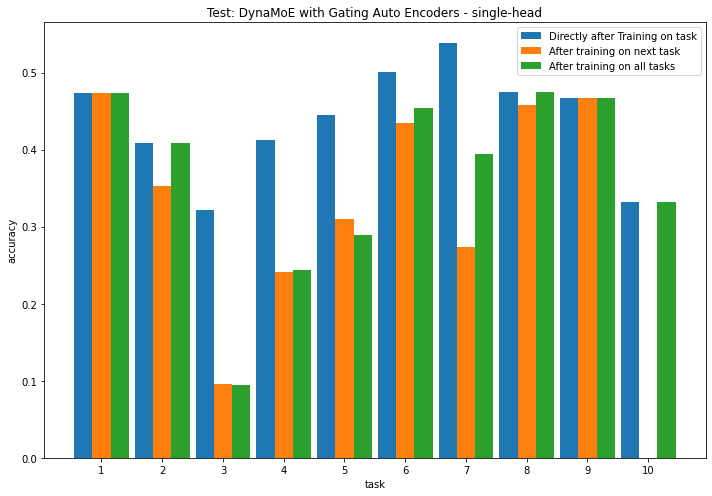

In [47]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_dmoe_gae, config_dmoe_gae)

The Aljundi Autoencoders do not learn the representation of the respective task good enough to generalize them from training to test-set.
Running theory is that the representations of the cnn layers are not powerful enough to distinguish the specific pictures of each task (Aljundi used the last Layer of AlexNet). Furthermore, with having a low amount of pixels the different pictures between groups are too similar to the difference of pictures within groups.
Possible solutions:
- Employ bigger cnn layers (defeats the purpose of comparability to Vogelstein paper)
- Build more complicated Autoencoders


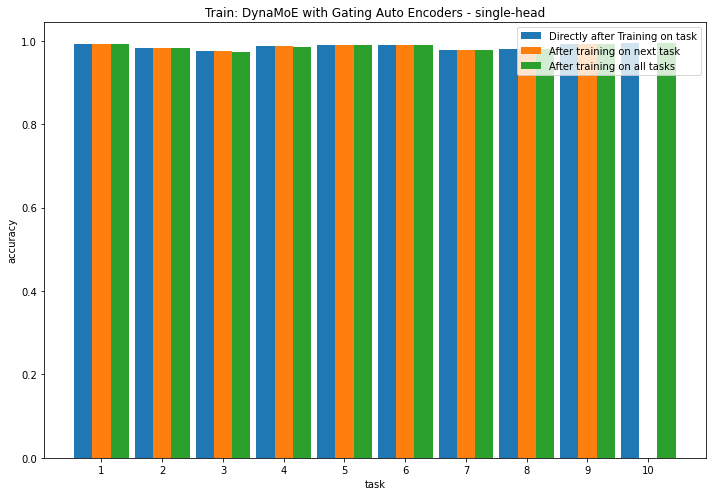

In [48]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_dmoe_gae, config_dmoe_gae, dataset=0)

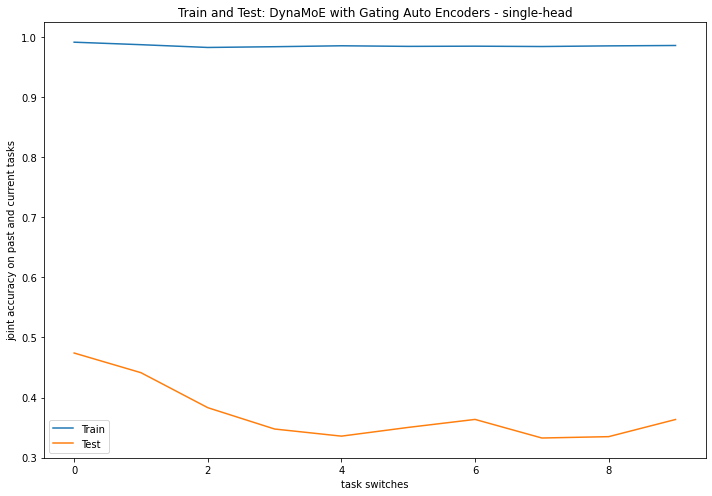

In [49]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_dmoe_gae, config_dmoe_gae)

# Tyler's Ensembling

### Expert (class)

In [65]:
class Expert(BaseClassifier):
    def __init__(self, config):
        super(Expert, self).__init__(config)

        # for readability in DynaMoE class
        self.opt = self.opts[0]

In [66]:
class GatingEnsembler(nn.Module):
    def __init__(self, config):
        super(GatingEnsembler, self).__init__()

        self.device = config["device"]
        self.convLayers = copy.deepcopy(config["convLayers"])
        self.combined_expert_dim = config["combined_expert_dim"]
        self.output_dim = config["output_dim"]

        self.convLayers.requires_grad_(False)

        self.fc_out = nn.Linear(
            self.convLayers.out_units + self.combined_expert_dim,
            self.output_dim,
        )

        self.to(self.device)

    def forward(self, X, expert_outputs):

        X1 = self.convLayers(X)

        combined = [torch.flatten(X1, start_dim=1)] + expert_outputs

        merged = torch.cat(combined, dim=1)

        return self.fc_out(merged)

### Ensembler (class)

In [67]:
class Ensembler(nn.Module):
    def __init__(self, config):
        super(Ensembler, self).__init__()

        self.config_expert = config["config_expert"]
        self.config_gating = config["config_gating"]
        self.device = config["device"]
        self.expert_class = config["expert_class"]
        self.max_experts = config["max_experts"]
        self.lr = config["learning_rate"]
        self.betas = config["betas"]

        self.input_dim_ensembling = (self.config_expert["output_dim"]
                                     * self.max_experts)
        self.output_dim = config["output_dim"]

        # experts
        self.n_experts = 0
        self.activated_experts = 1
        self.curr_expert = 0

        for _ in range(self.max_experts):
            self.new_expert()

        # Gating
        self.config_gating["combined_expert_dim"] = \
            self.max_experts * self.config_expert["output_dim"]
        self.config_gating["output_dim"] = config["output_dim"]
        self.gating = GatingEnsembler(self.config_gating)
        self.set_mode("train_expert_gating")
        self.update_opt()

        self.to(self.device)

    def forward(self, X, show_gating=False):
        batch_size = X.shape[0]

        expert_outputs = []
        # Gather active expert outputs
        for e_id in range(self.activated_experts):
            expert = self.get_submodule(f"expert{e_id}")
            expert_outputs.append(expert(X))

        # Unactive experts return 0
        for e_id in range(self.activated_experts, self.n_experts):
            expert_outputs.append(
                torch.zeros(
                    (batch_size, self.config_expert["output_dim"],),
                    device=self.device,
                )
            )

        return self.gating(X, expert_outputs)

    def new_expert(self):
        """Creates a new expert."""

        name = f"expert{self.n_experts}"

        self.add_module(
            name,
            self.expert_class(self.config_expert).to(self.device)
        )
        self.n_experts += 1

    def update_opt(self):
        self.opt = optim.AdamW(
            [param for param in self.parameters() if param.requires_grad],
            lr=self.lr,
            betas=self.betas,
        )

    def task_update(self):
        """
        if training on expert and gating, stop doing that and change mode
        """
        self.set_mode("train_gating")

    def set_mode(self, mode_string):
        """
        Sets the mode of the Ensembler, determines what the next mode is

        Parameters
        ----------
        mode_string: string
            "train_expert_gating": Train expert and gating
            "train_gating": trains only gating
            "enable_new_expert": creates a new expert
        """
        self.epoch_count = 0
        self.mode = mode_string
        if (mode_string == "train_gating"):
            print("----------------------------------- PHASE: TRAIN GATING")
            # Set all experts to eval
            for e_id in range(self.activated_experts):
                name = f"expert{e_id}"
                expert = self.get_submodule(name)
                expert.eval()
                expert.requires_grad_(False)

            self.next_mode = "enable_new_expert"

        elif mode_string == "enable_new_expert":
            self.curr_expert += 1
            self.activated_experts += 1
            print("----------------------------------- ENABLED OTHER EXPERT")
            self.set_mode("train_expert_gating")

        elif mode_string == "train_expert_gating":
            print("----------------------------------- PHASE: TRAIN EXPERT AND GATING")
            # Set last expert to train
            for e_id in range(self.activated_experts):
                name = f"expert{e_id}"
                expert = self.get_submodule(name)
                if e_id == self.curr_expert:
                    expert.train()
                    expert.requires_grad_(True)
                else:
                    expert.eval()
                    expert.requires_grad_(False)

            self.next_mode = "train_gating"
        else:
            raise NotImplementedError(f"Incorrect mode: {mode_string}")

### training functions

#### train_ensembler

In [68]:
def train_ensembler(model, dataloader, criterion, clip):

    epoch_loss = 0

    for X, y in dataloader:

        X = X.to(DEVICE)
        y = y.to(DEVICE)

        model.opt.zero_grad()

        output = model(X)
        del X

        loss = criterion(output, y)
        del y

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        model.opt.step()

        epoch_loss += loss.item()
        del loss

    return epoch_loss / len(dataloader)

#### fit_ensembler

In [69]:
def fit_ensembler(
    model,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            evaluate_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)

        start_time = time.time()

        train_loss = train_ensembler(model, dls_train[task_id], criterion, clip)
        # Test hits performance
        accuracy = evaluate(model, dls_train[task_id], hitsLoss)
        model.epoch_count +=1

        end_time = time.time()

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            evaluate_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        # If after some time model cannot solve task without training new
        # expert, then initialize a new one and train with it.
        if (model.mode == "train_gating"
            and accuracy < config["desired_performance"]
            and model.epoch_count >= config["limit_epochs_new_mode"]
        ):
            model.set_mode(model.next_mode)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tTrain Acc: {accuracy:.3f}')

    if eval_within:
        return total_loss, total_hits
    return None, None

repeat_func, init_func

In [70]:
def init_func_ensembler(config):
    nmodel = Ensembler(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = None
    return nmodel, criterion, pass_on_variables

def repeat_func_ensembler(model, criterion, config, pass_on_variables):

    fit_ensembler(model, criterion, config)

    model.task_update()

    return model, None, None

#### config_ensembler_expert

In [71]:
config_ensembler_expert = {
    "device": DEVICE,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": 2000,
    "output_dim": OUTPUT_DIM,
    "multi_head": False,
}

#### config_ensembler_gating

In [72]:
config_ensembler_gating = {
    "device": DEVICE,
    "convLayers": convLayers,
}

#### config_ensembler

In [73]:
"""
New Parameters
--------------
desired_performance : float[0,1]
    Desired performance of model on training set in ratio of accuractly
    classified examples.
limit_duration : int
    Amount of epochs model is trained until it initializes a new expert
threshhold_accuracy_loss : float [0,1]
    Percentage of accuracy loss between epochs, if it is above during
    training, the network will consolidate its weights
    [not used, since Tsuda are not doing that but giving a task_change signal]
"""

config_ensembler = {
    "experiment_name": "dynamoe",
    "n_repetitions": N_REPETITIONS,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "batch_size": BATCH_SIZE,
    "device": DEVICE,
    "schedule": not_interleaved,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "config_expert": config_ensembler_expert,
    "config_gating": config_ensembler_gating,
    "multi_head": False,
    "desired_performance": 0.98,
    "limit_epochs_new_mode": 2,
    "threshhold_accuracy_loss": 0.25,
    "expert_class": Expert,
    "max_experts": 10,
    "output_dim": OUTPUT_DIM,
}
# debug
# config_dmoe["schedule"] = dbg_not_interleaved
config_ensembler["n_repetitions"] = 1

#### experiment

In [74]:
hist_losses_ensembler, hist_hitsss_ensembler, _, _, models = \
    experiment(config_ensembler, init_func_ensembler, repeat_func_ensembler)

@@@@@@@@@ Repetition   0 @@@@@@@@@
----------------------------------- PHASE: TRAIN EXPERT AND GATING

SCHEDULE: dynamoe.s0.t0.e20
Epoch: 01 | Time: 0m 2s | R0 T0
	Train Loss: 1.596 | Train PPL:   4.932
	Train Acc: 0.583
Epoch: 02 | Time: 0m 4s | R0 T0
	Train Loss: 1.124 | Train PPL:   3.078
	Train Acc: 0.704
Epoch: 03 | Time: 0m 9s | R0 T0
	Train Loss: 0.879 | Train PPL:   2.407
	Train Acc: 0.789
Epoch: 04 | Time: 0m 7s | R0 T0
	Train Loss: 0.674 | Train PPL:   1.961
	Train Acc: 0.817
Epoch: 05 | Time: 0m 6s | R0 T0
	Train Loss: 0.533 | Train PPL:   1.704
	Train Acc: 0.892
Epoch: 06 | Time: 0m 7s | R0 T0
	Train Loss: 0.390 | Train PPL:   1.476
	Train Acc: 0.931
Epoch: 07 | Time: 0m 6s | R0 T0
	Train Loss: 0.282 | Train PPL:   1.325
	Train Acc: 0.937
Epoch: 08 | Time: 0m 7s | R0 T0
	Train Loss: 0.226 | Train PPL:   1.253
	Train Acc: 0.977
Epoch: 09 | Time: 0m 7s | R0 T0
	Train Loss: 0.175 | Train PPL:   1.191
	Train Acc: 0.969
Epoch: 10 | Time: 0m 7s | R0 T0
	Train Loss: 0.138 | Train 

### results

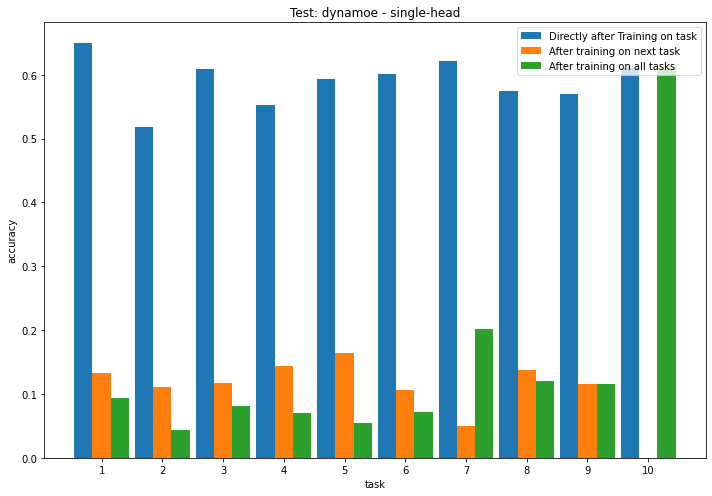

In [76]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_ensembler, config_ensembler)

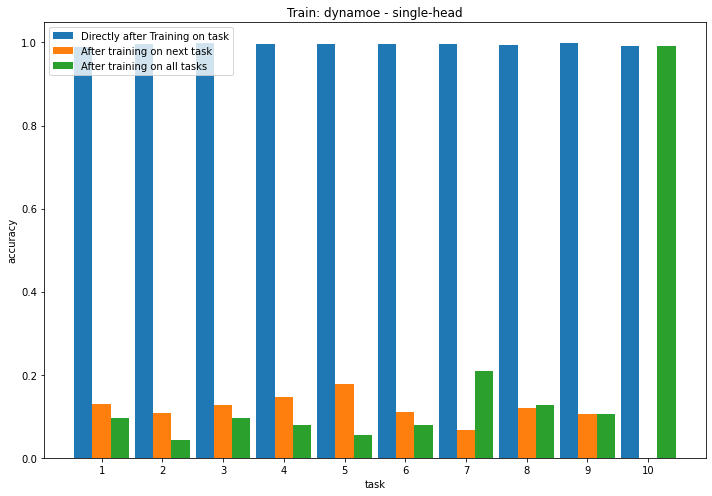

In [77]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_ensembler, config_ensembler, dataset=0)

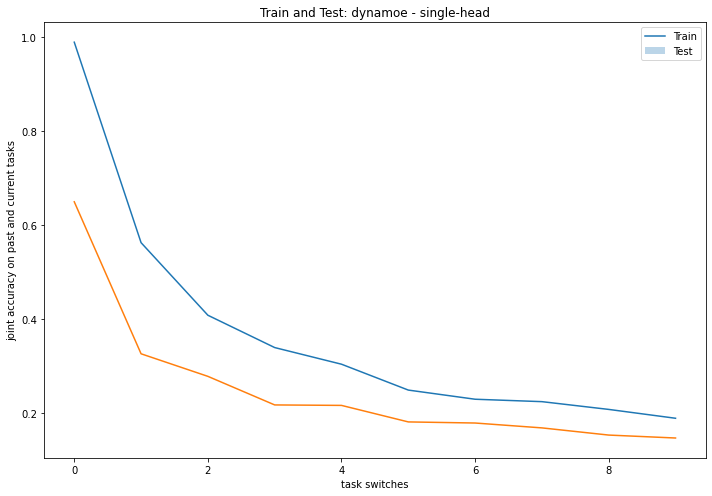

In [78]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_ensembler, config_ensembler)

In [80]:
ensembler = models[0]
ensembler.set_mode("train_gating")

In [107]:
losses, hitss = evaluate_with_training(config_ensembler, ensembler, train_ensembler, "single")

Evaluating


<BarContainer object of 10 artists>

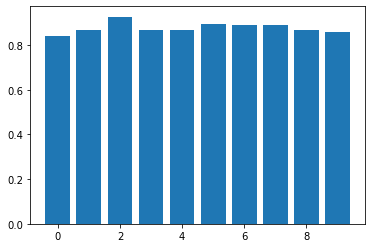

In [109]:
plt.bar(range(N_TASKS), hitss[0])